In [1]:
import os
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy.plot as ep
import fiona
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [2]:
base_dir = os.getcwd()
print(base_dir)
data_dir = os.path.join(base_dir)
print(data_dir)
raster_data = os.path.join(data_dir, "planet_2021-09_005_noval.tif")
sample_data = os.path.join(data_dir, "Classes_V4_smallarea.shp")
result_data = os.path.join(base_dir, "Classified_preylang")

/home/ubuntu/Space4Good/Combodia/Code
/home/ubuntu/Space4Good/Combodia/Code


# Open raster files

In [3]:
dataset = rasterio.open(raster_data)

In [4]:
raster_data_im = dataset.read(masked=True)[1]
extent = rasterio.plot.plotting_extent(dataset)
raster_profile = dataset.profile
print(raster_profile)

# ep.plot_bands(raster_data_im,
#                cmap='terrain',
#                extent=extent,
#                title="Sentinel 1",
#                cbar=False);

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 16384, 'height': 16384, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(4.284963909912103e-05, 0.0, 104.862215114,
       0.0, -4.1605004394531294e-05, 14.182661499), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


# Open shape file

In [5]:
samples = gpd.read_file(sample_data)
samples.head()

,id,Name,Class,geometry
0,1,water,water,"POLYGON ((104.94530 13.83765, 104.94812 13.839..."
1,1,water,water,"POLYGON ((105.01021 13.80510, 105.00981 13.804..."
2,3,forest,forest,"POLYGON ((105.40651 13.70209, 105.40787 13.699..."
3,3,forest,forest,"POLYGON ((105.03576 14.02997, 105.04129 14.027..."
4,1,water,water,"POLYGON ((104.99559 13.97282, 104.99856 13.972..."


In [6]:
# projection
samples.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Plot shapefile

In [7]:
# fig, ax = plt.subplots()
# samples.plot(ax=ax)
# ax.set_title("Shapefile \n Training Samples", 
#              fontsize = 10)
# ax.set_axis_off();
# plt.show()

In [8]:
# fig, ax = plt.subplots(figsize=(3, 3))
# ep.plot_bands(raster_data_im,
#               cmap='terrain',
#               extent=extent,
#               ax=ax,
#               cbar=False)
# samples.plot(ax=ax, alpha=.6, color='r');
# plt.show()

# Read sample polygones and class names

In [9]:
shapefile = fiona.open(sample_data, 'r')
shapes_list = []
cl_name_list = []
for feature in shapefile:
    shapes = feature["geometry"]
    shapes_list.append(shapes)
    prop = feature["properties"]
    cl_name = prop["Class"]
    cl_name_list.append(cl_name)
print(cl_name_list)

['water', 'water', 'forest', 'forest', 'water', 'agri', 'agri', 'deforestation', 'deforestation', 'agri', 'deforestation', 'deforestation', 'forest', 'deforestation', 'agri', 'agri', 'agri', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'agri', 'agri', 'agri', 'agri', 'agri', 'deforestation', 'agri', 'agri', 'agri', 'deforestation', 'agri']


# Unique class names

In [10]:
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)      
    return unique_list 

In [11]:
cl_unq = unique(cl_name_list)
print('Number of classes = ', len(cl_unq))
print("Class names are:")
print(cl_unq)

Number of classes =  5
Class names are:
['water', 'forest', 'agri', 'deforestation', 'other']


# Assigne unique number to each class

In [12]:
def Convert(class_list):
    cl_dct={} 
    for i in range(0, len(class_list)):
        cl_dct[class_list[i]] =  (i + 1)
    return cl_dct

In [13]:
dict_cl_unq = Convert(cl_unq)
print(dict_cl_unq)

{'water': 1, 'forest': 2, 'agri': 3, 'deforestation': 4, 'other': 5}


In [14]:
def get_val(cl,my_dict):
    for key, value in my_dict.items():
         if cl == key:
            return value

In [15]:
nomb_label=get_val("water",dict_cl_unq)
print("water = ",nomb_label)

water =  1


# Crop the raster image by sampleing polygons

In [16]:
out_image_list = [rasterio.mask.mask(dataset, [shapes], crop=True) for shapes in shapes_list]

In [17]:
cl_number_list = []
for polygon in shapefile:
    prop_pol = polygon['properties']
    cl_name = prop_pol['Class']
    cl_number = dict_cl_unq[cl_name]
    cl_number_list.append(cl_number)
    print(cl_name, "=", cl_number)
print(cl_number_list)   


water = 1
water = 1
forest = 2
forest = 2
water = 1
agri = 3
agri = 3
deforestation = 4
deforestation = 4
agri = 3
deforestation = 4
deforestation = 4
forest = 2
deforestation = 4
agri = 3
agri = 3
agri = 3
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
other = 5
agri = 3
agri = 3
agri = 3
agri = 3
agri = 3
deforestation = 4
agri = 3
agri = 3
agri = 3
deforestation = 4
agri = 3
[1, 1, 2, 2, 1, 3, 3, 4, 4, 3, 4, 4, 2, 4, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3]


In [18]:
# Assigne class numbers to each tuple
crop_image_labed = []
for i in range(len(out_image_list)):
    masked_pol = out_image_list[i]
    cl_number_ord = cl_number_list[i]
    crop_image_o = masked_pol + (cl_number_ord,)
    crop_image_labed.append(crop_image_o)

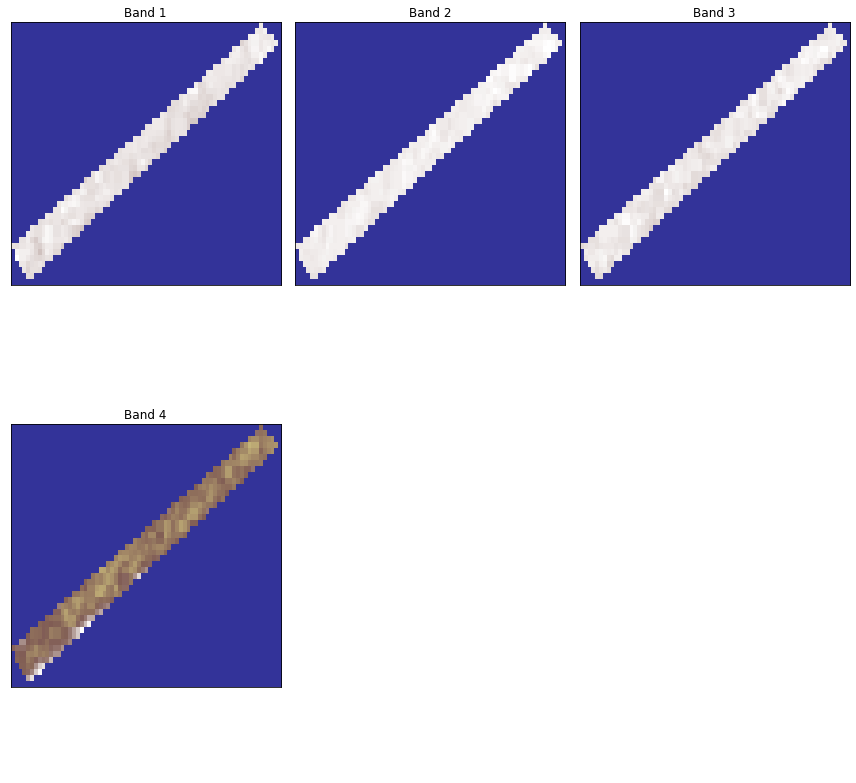

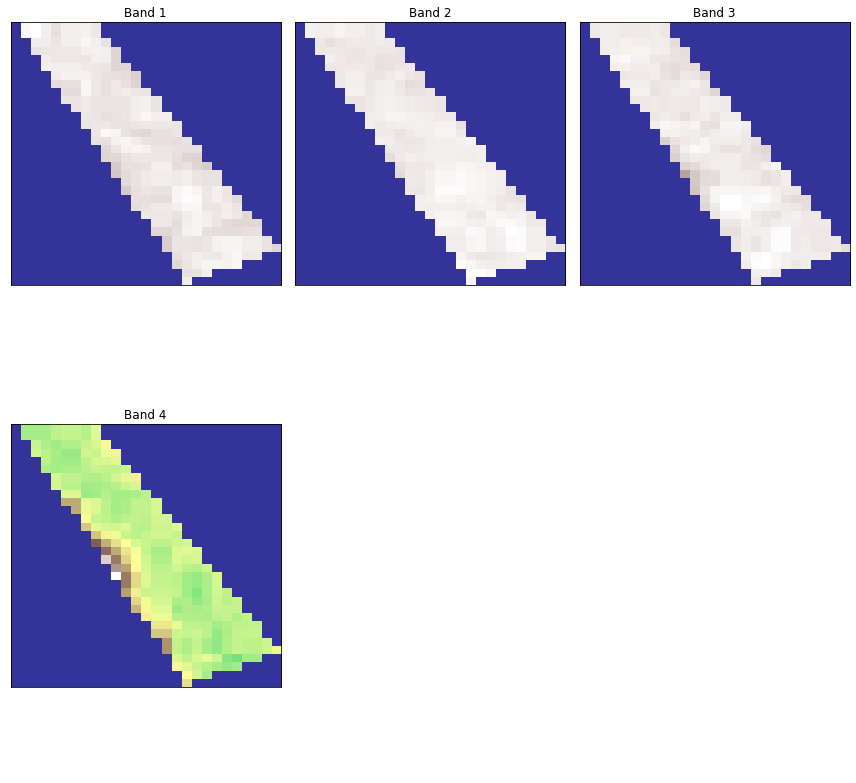

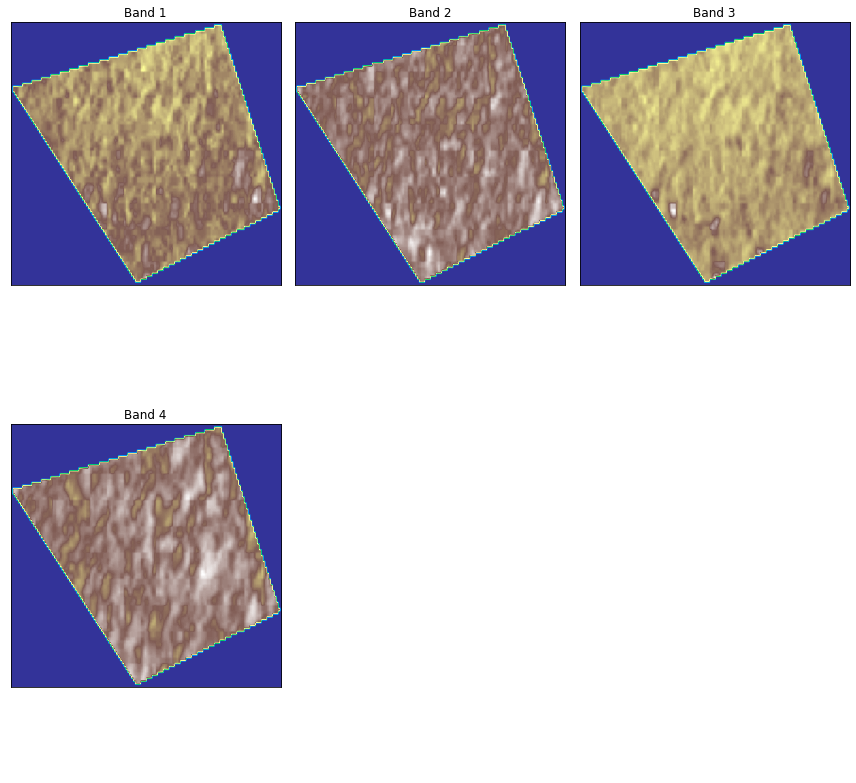

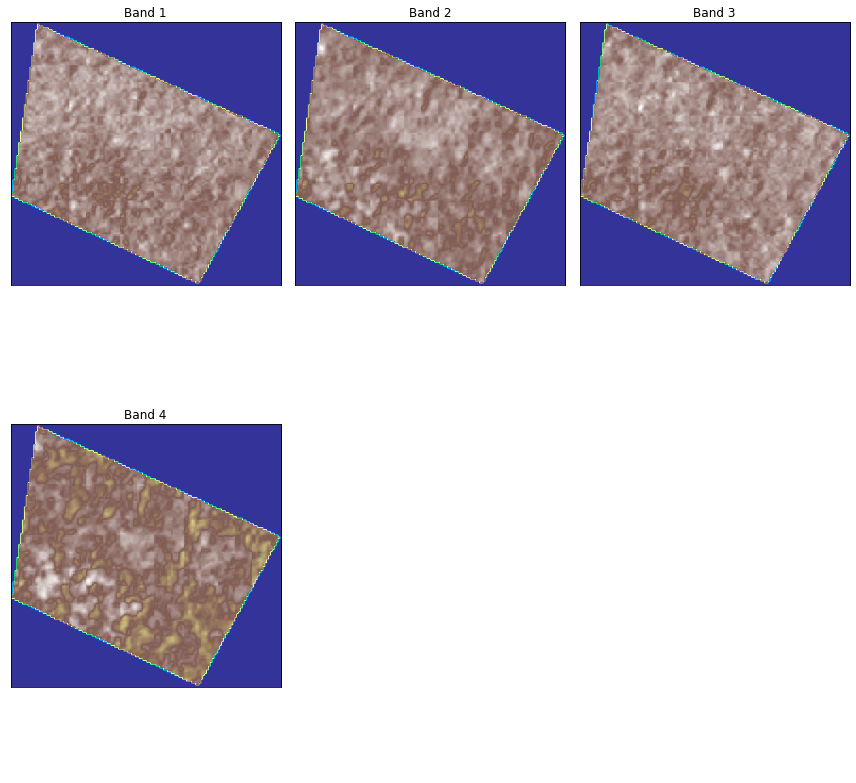

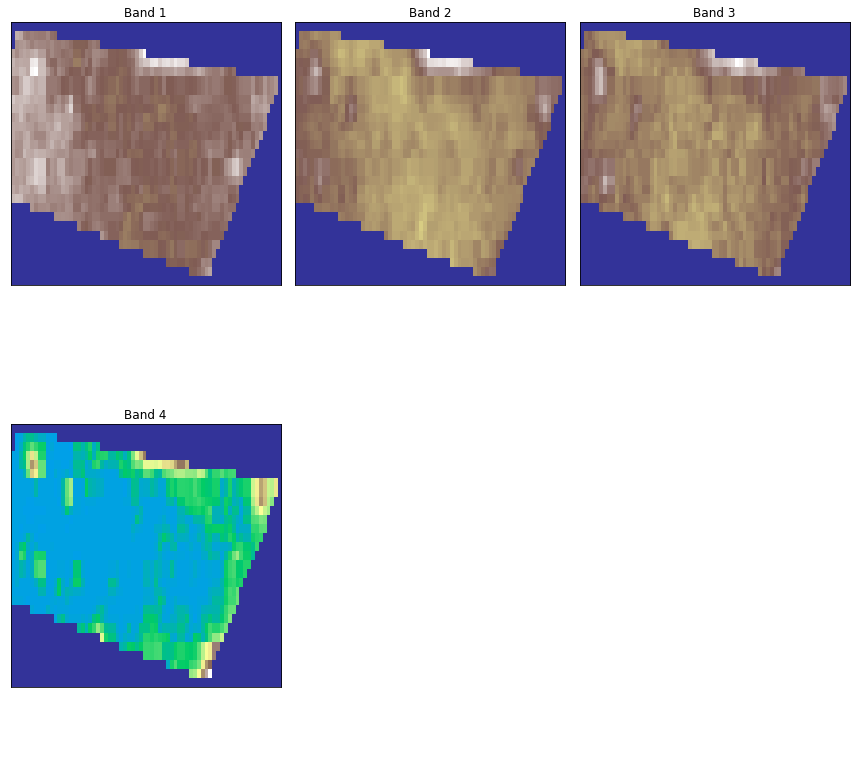

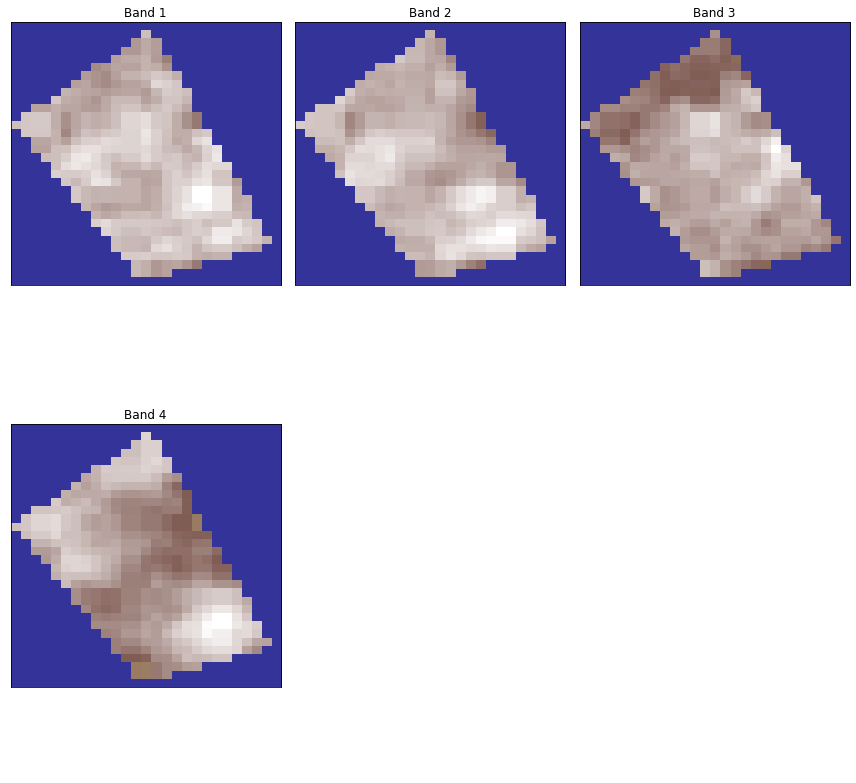

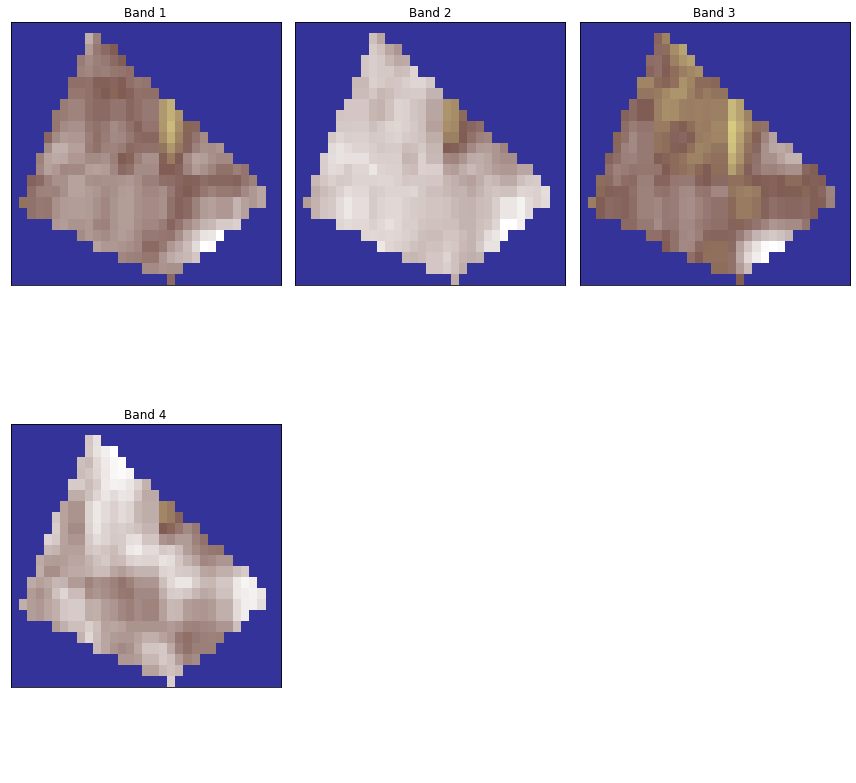

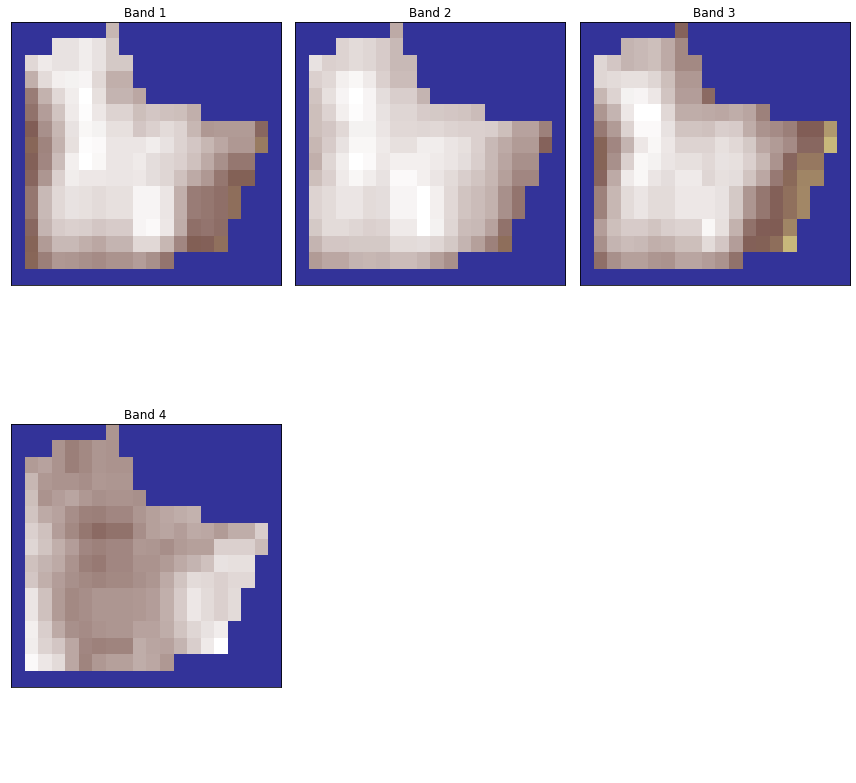

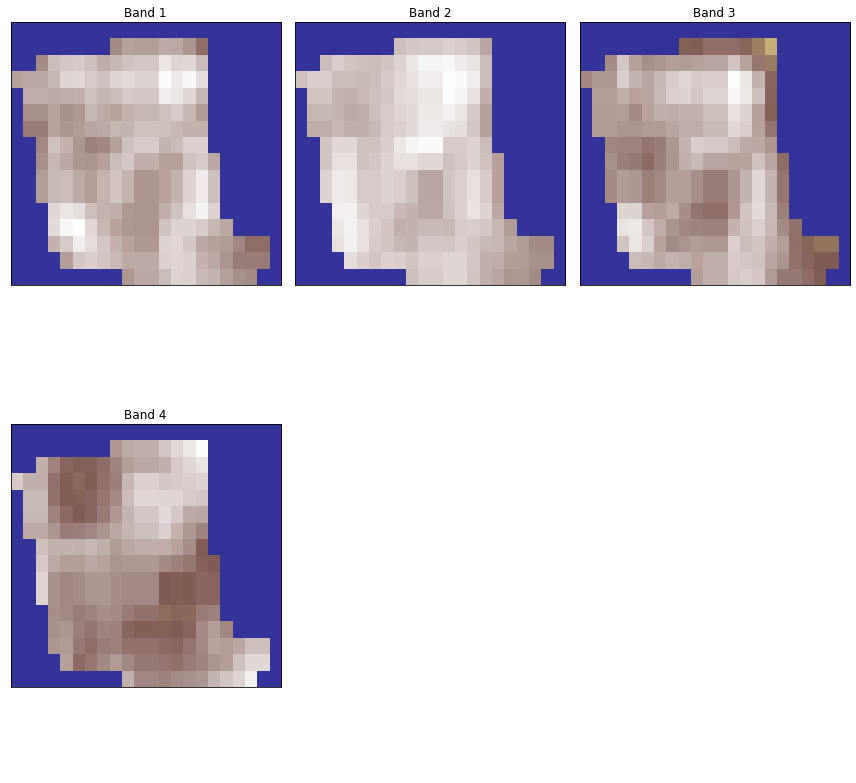

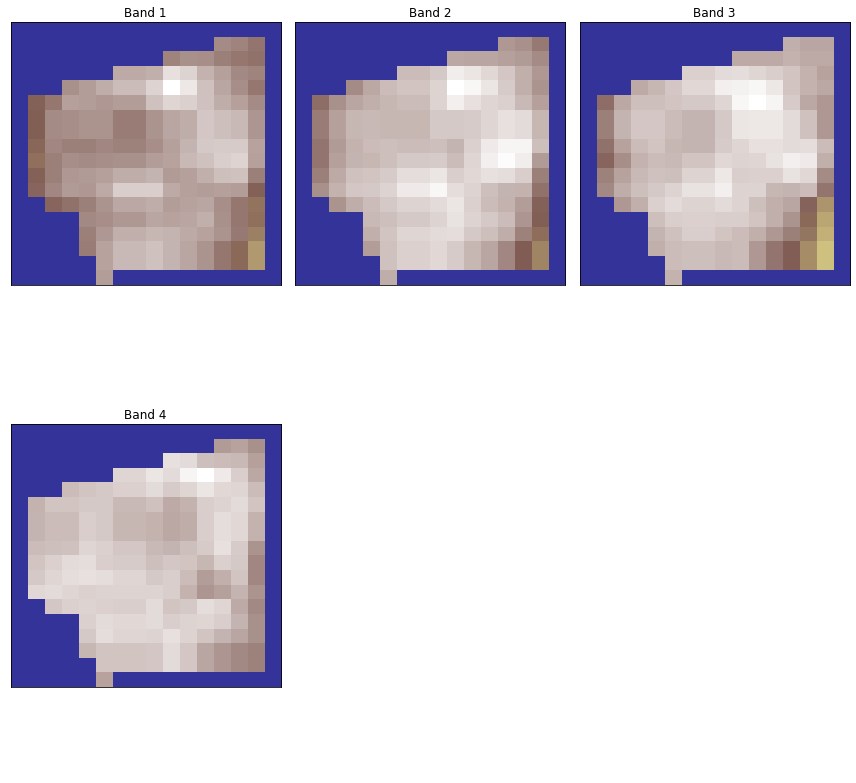

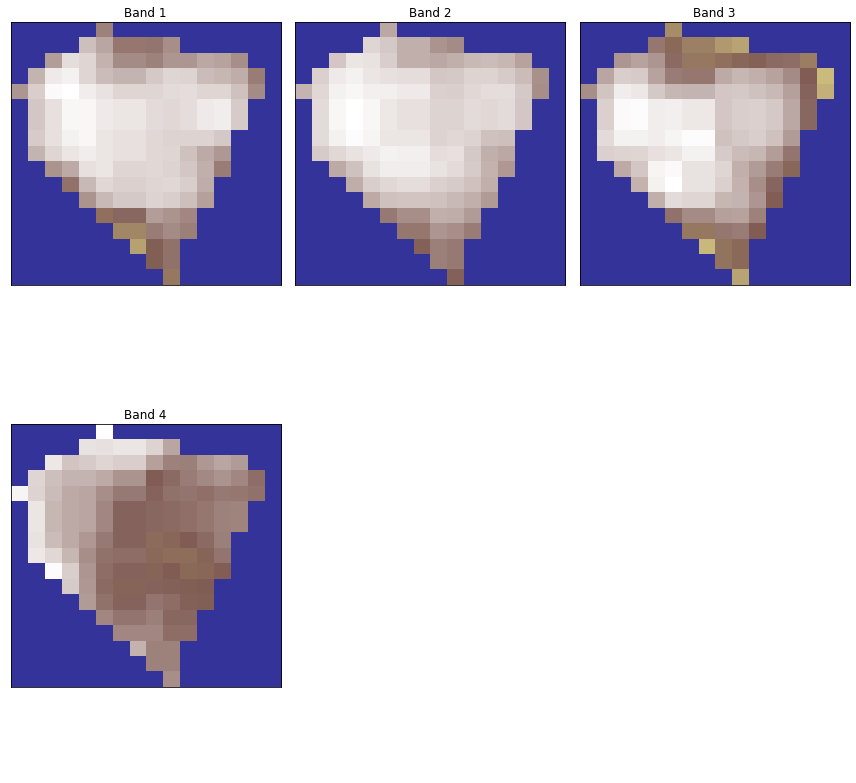

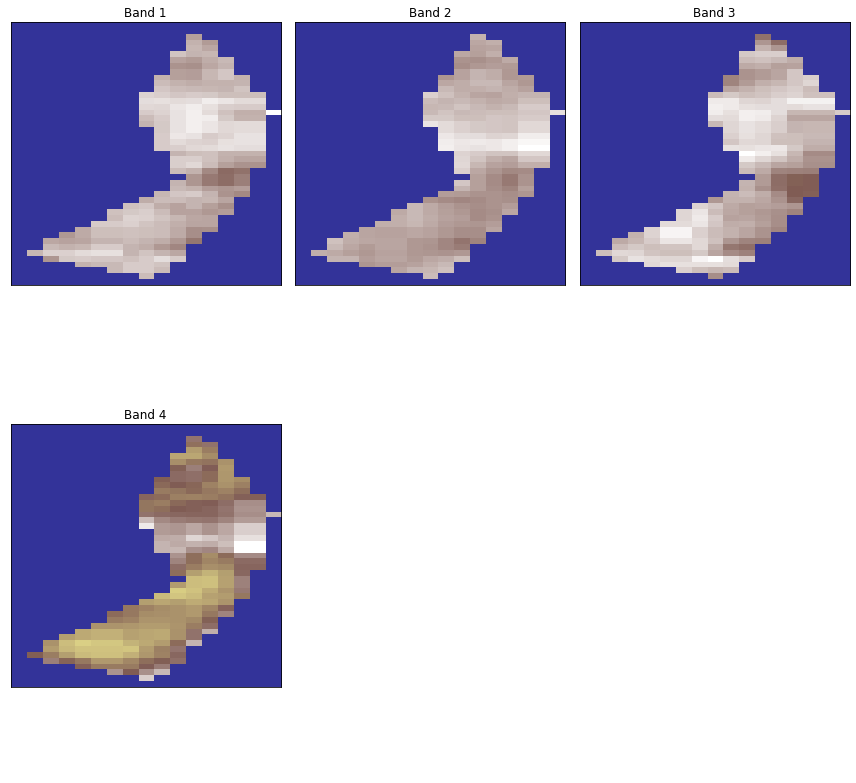

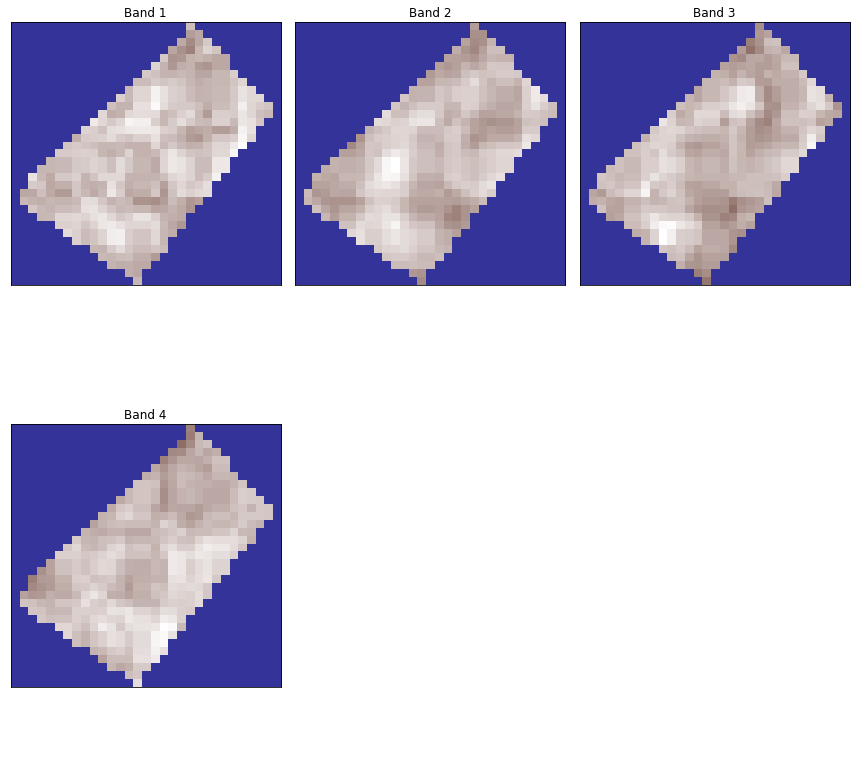

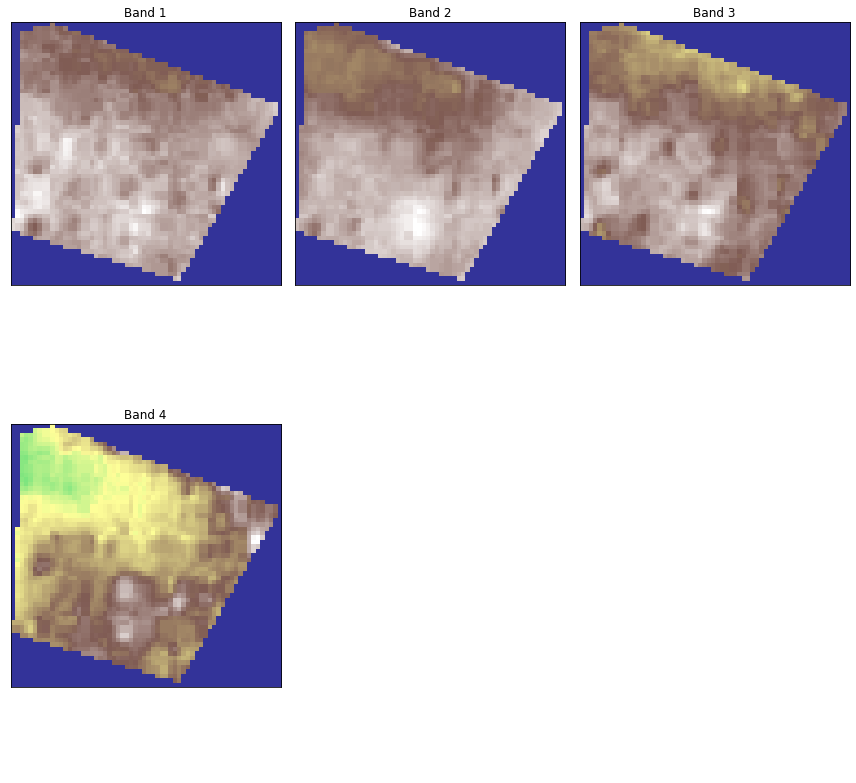

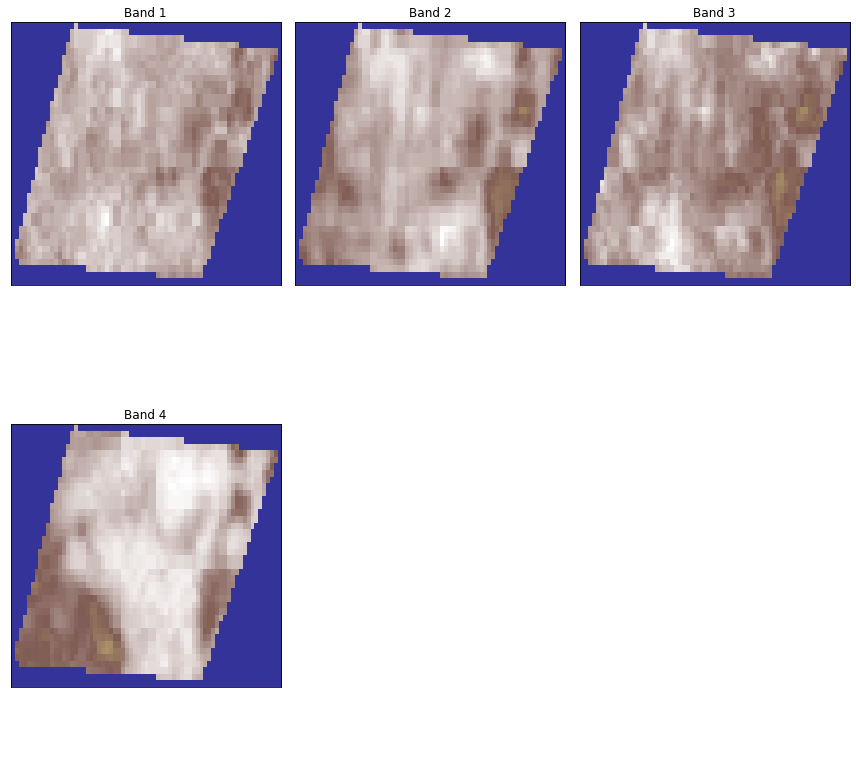

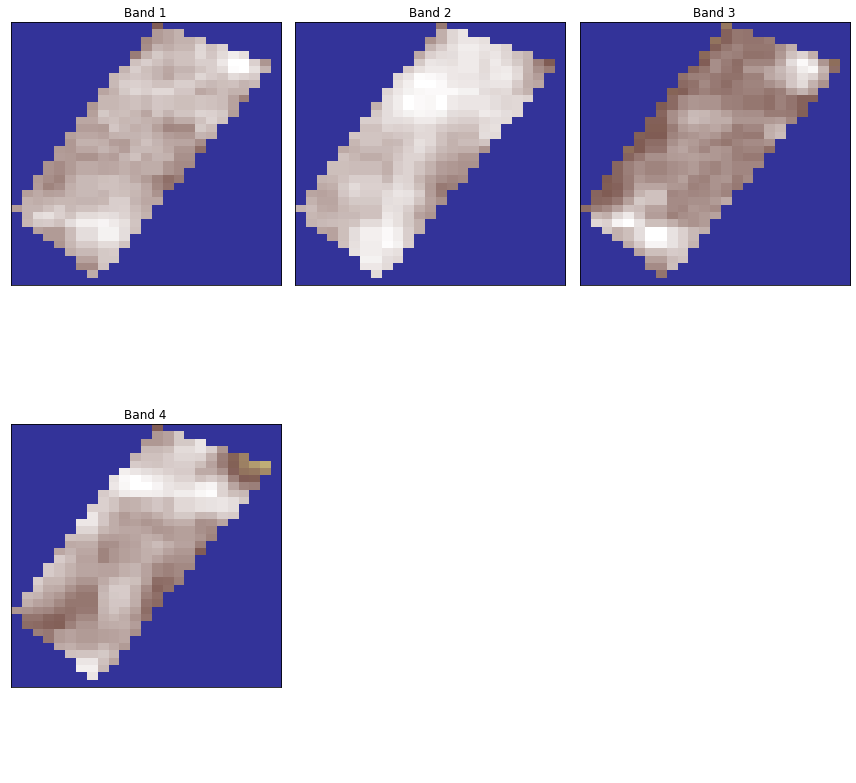

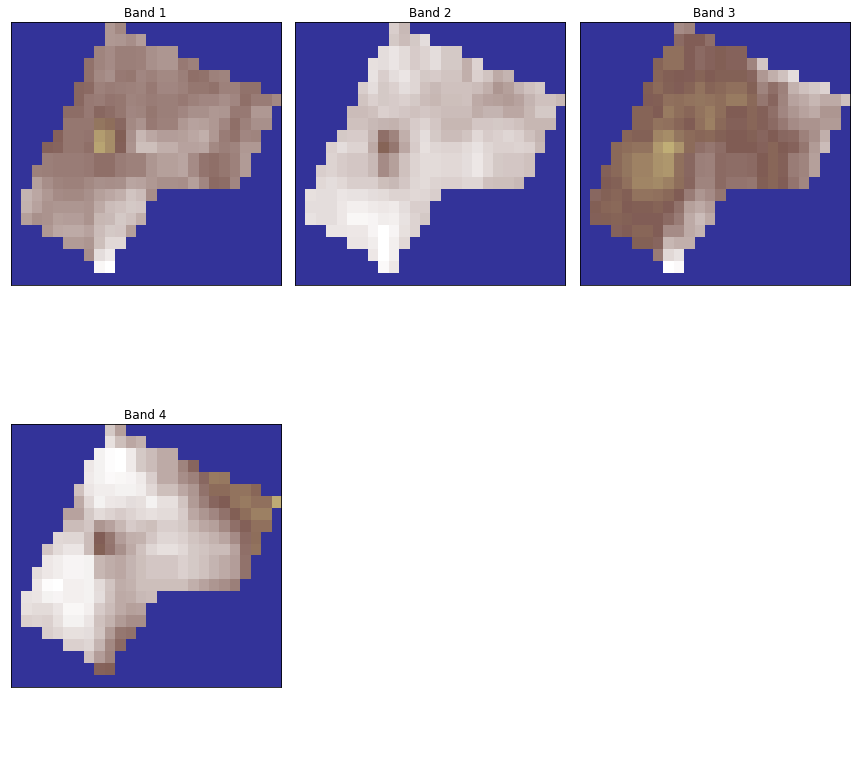

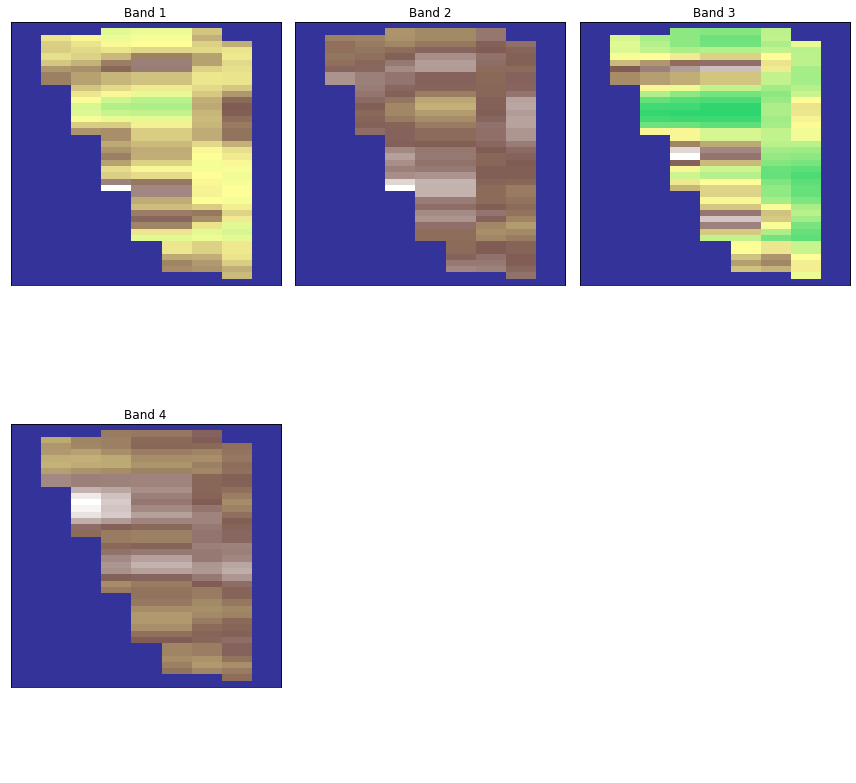

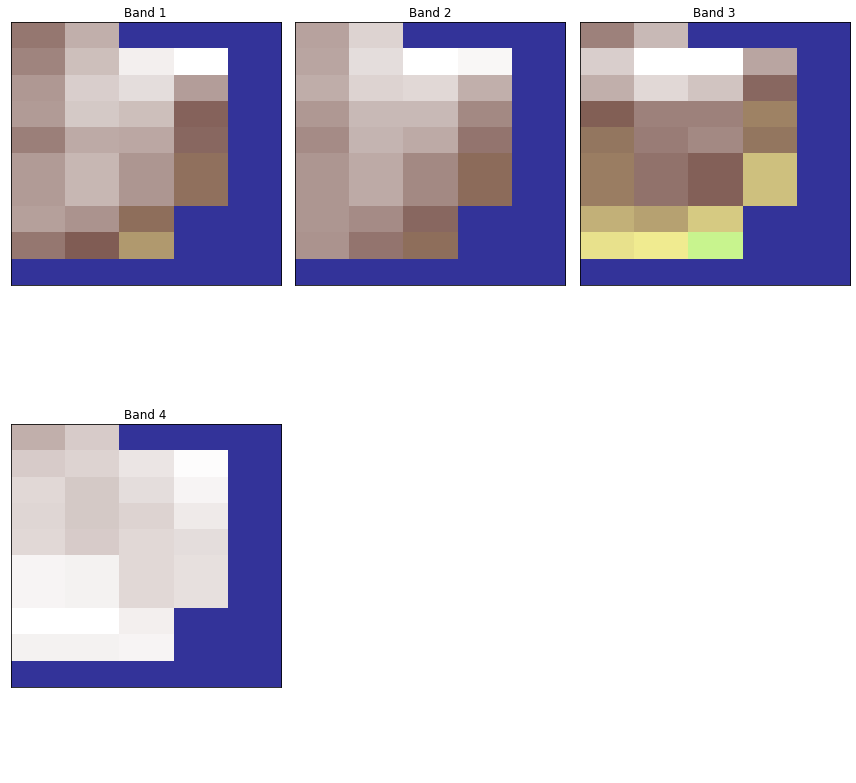

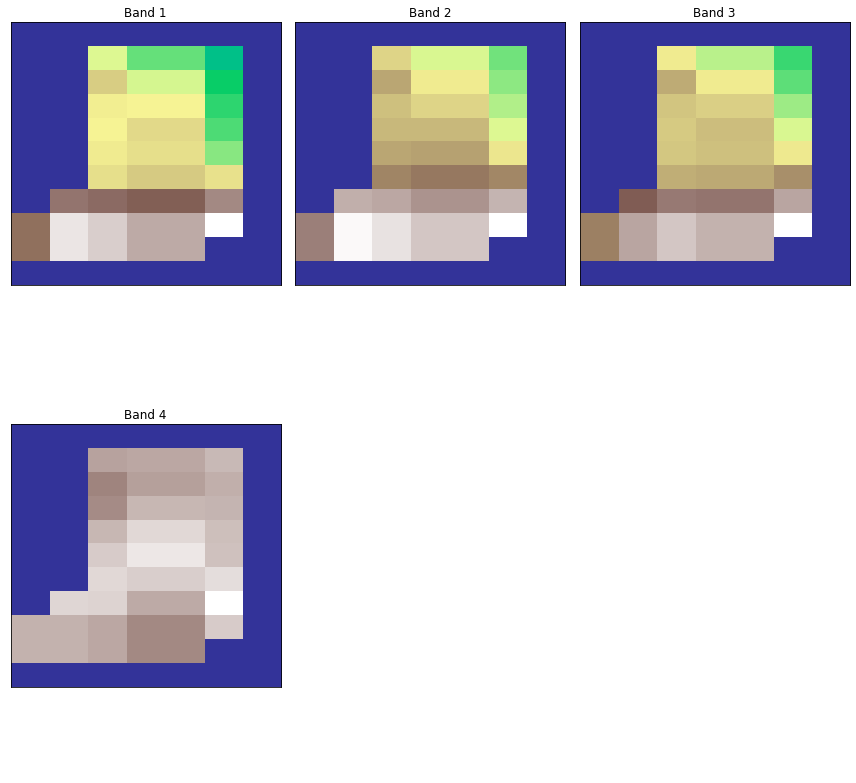

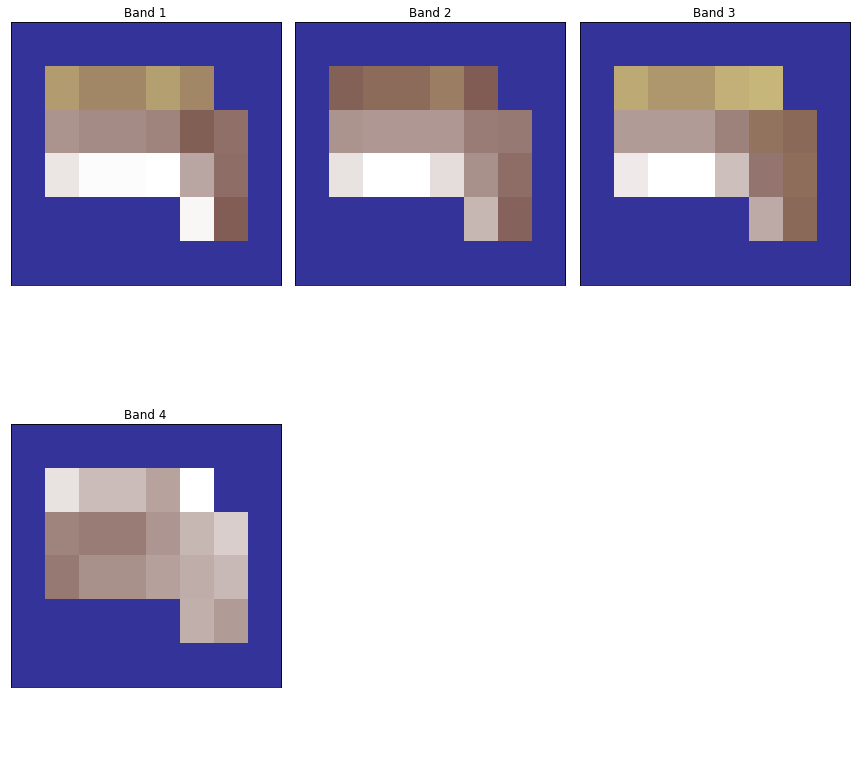

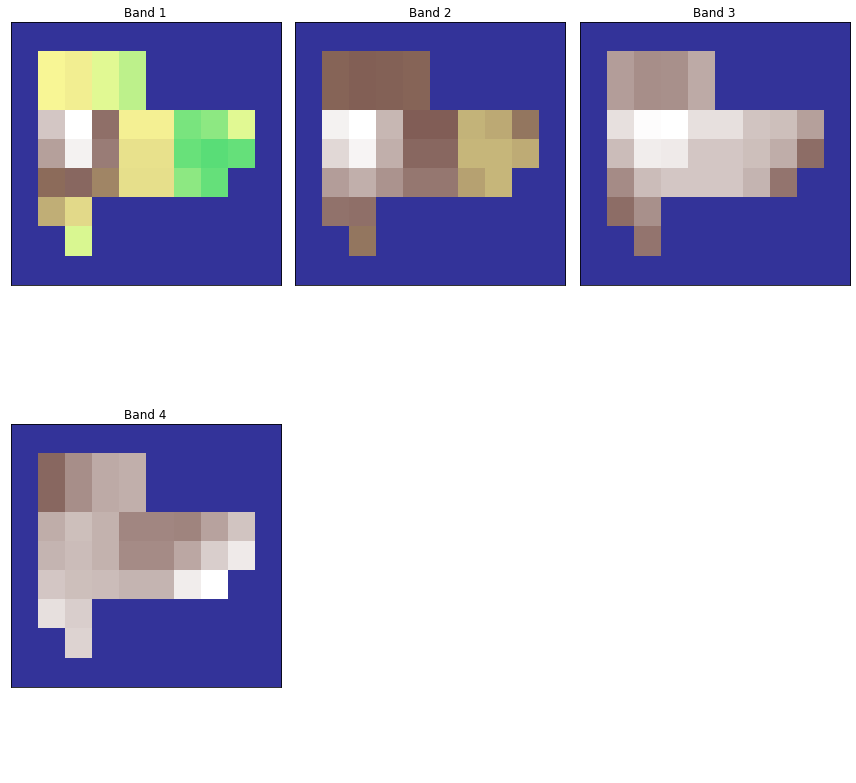

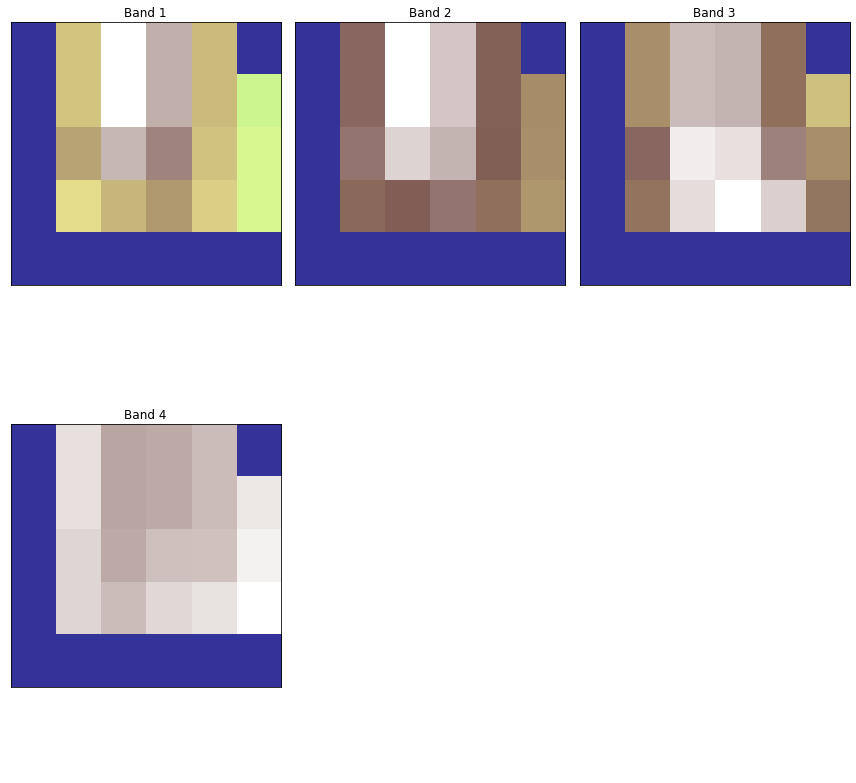

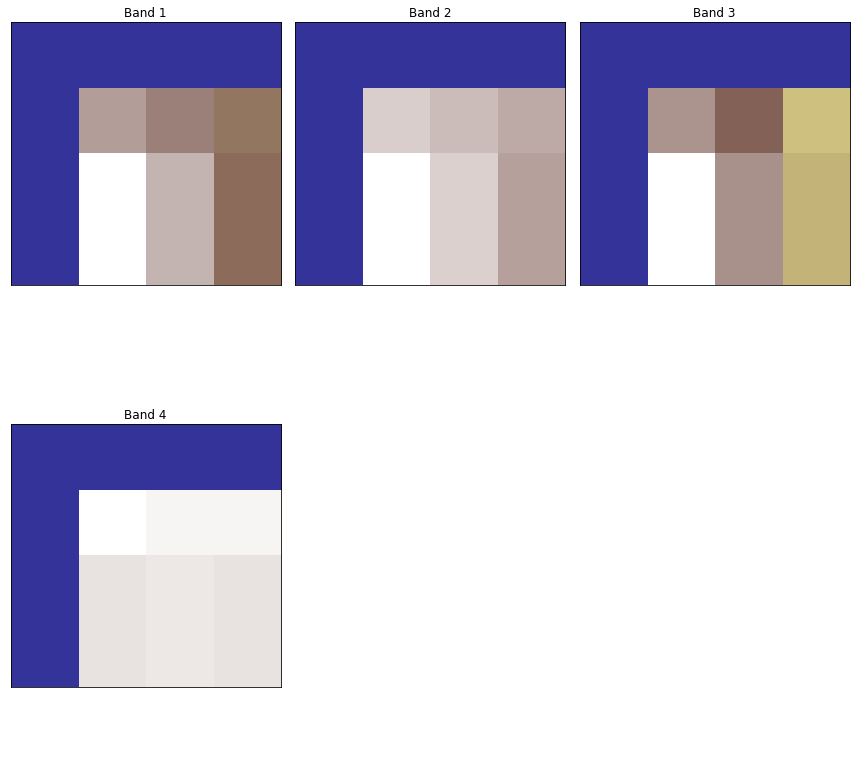

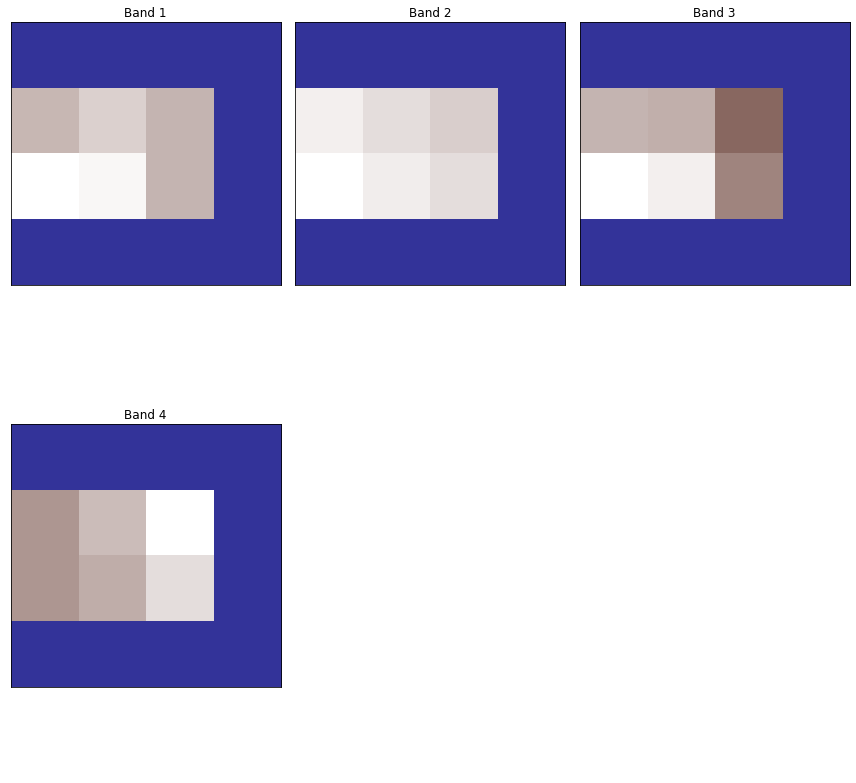

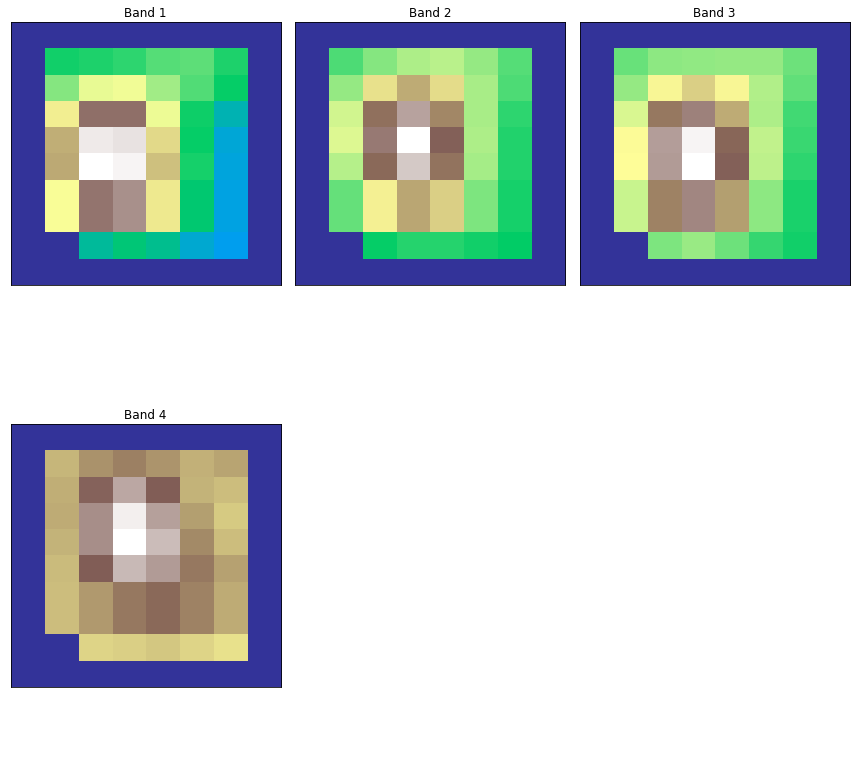

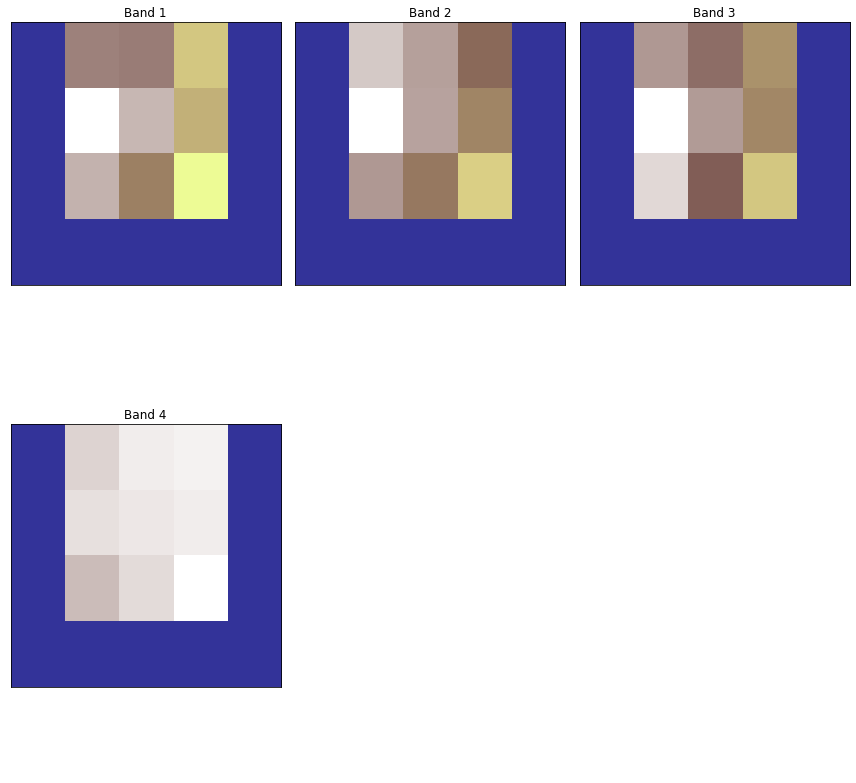

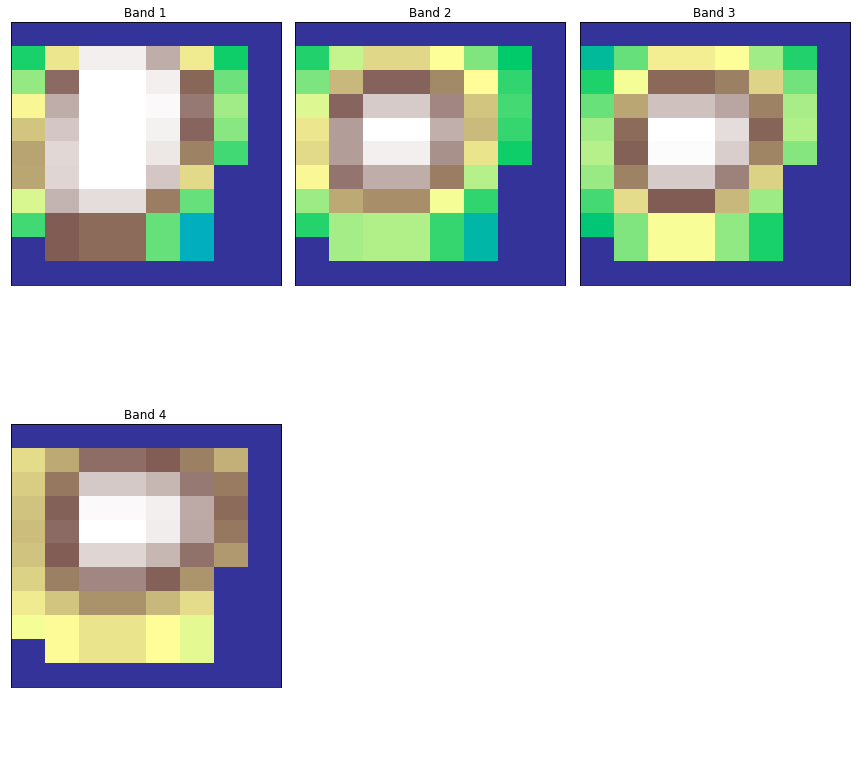

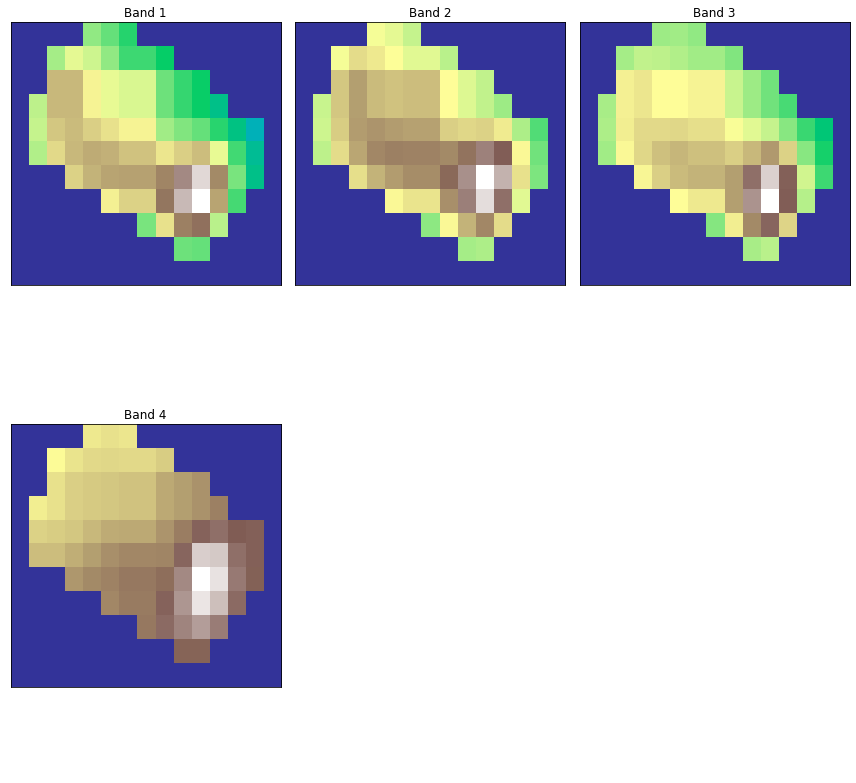

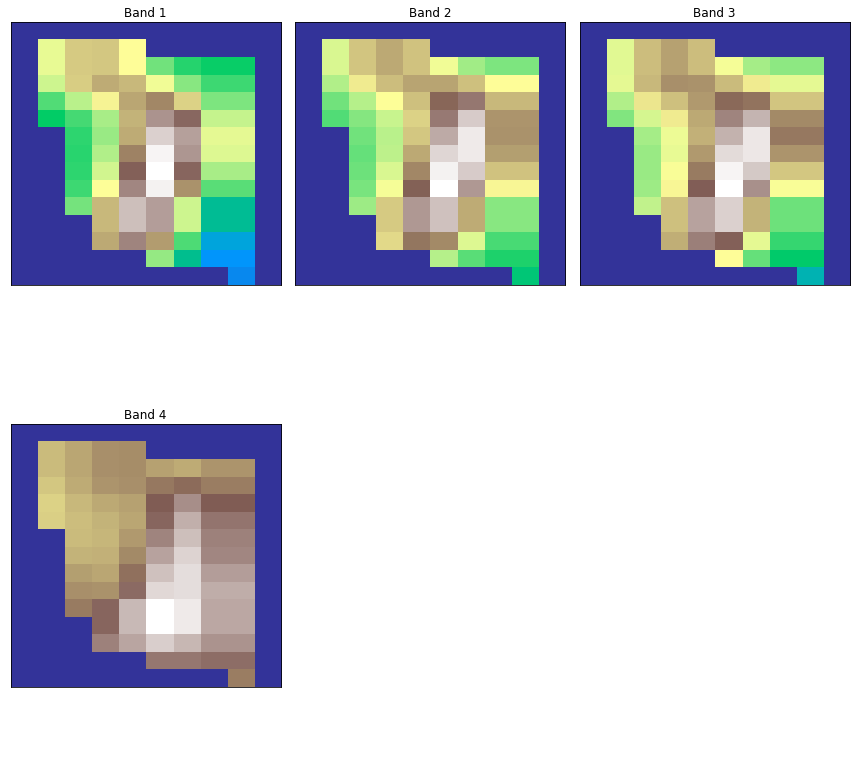

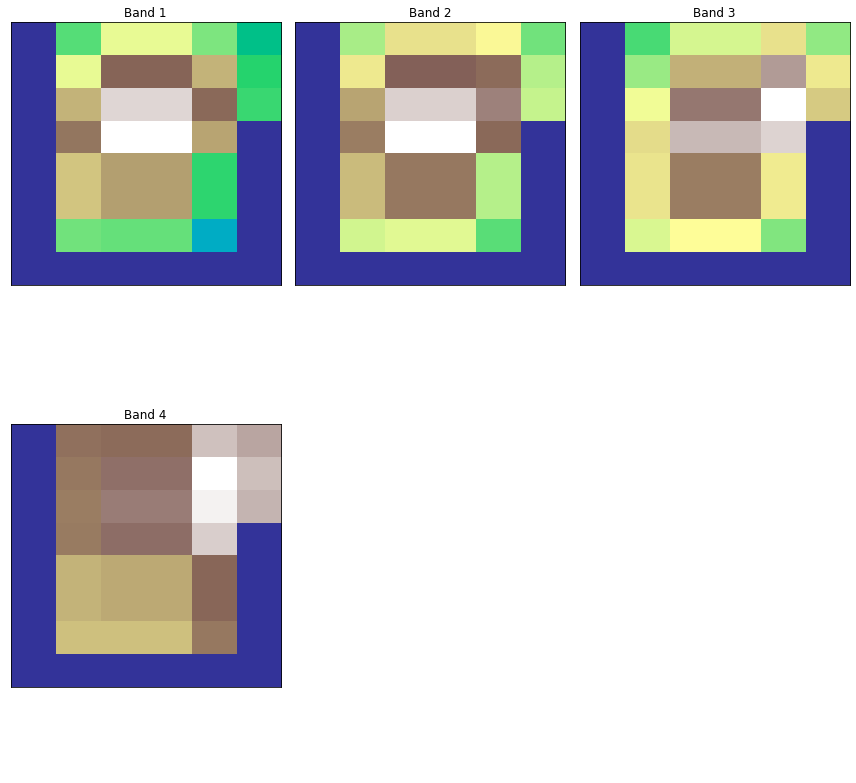

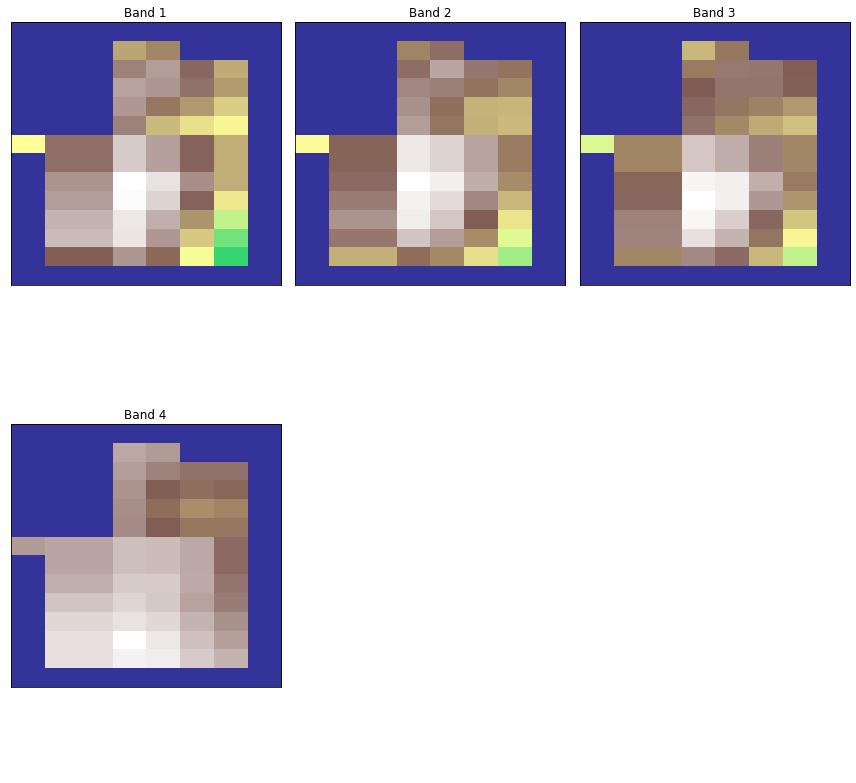

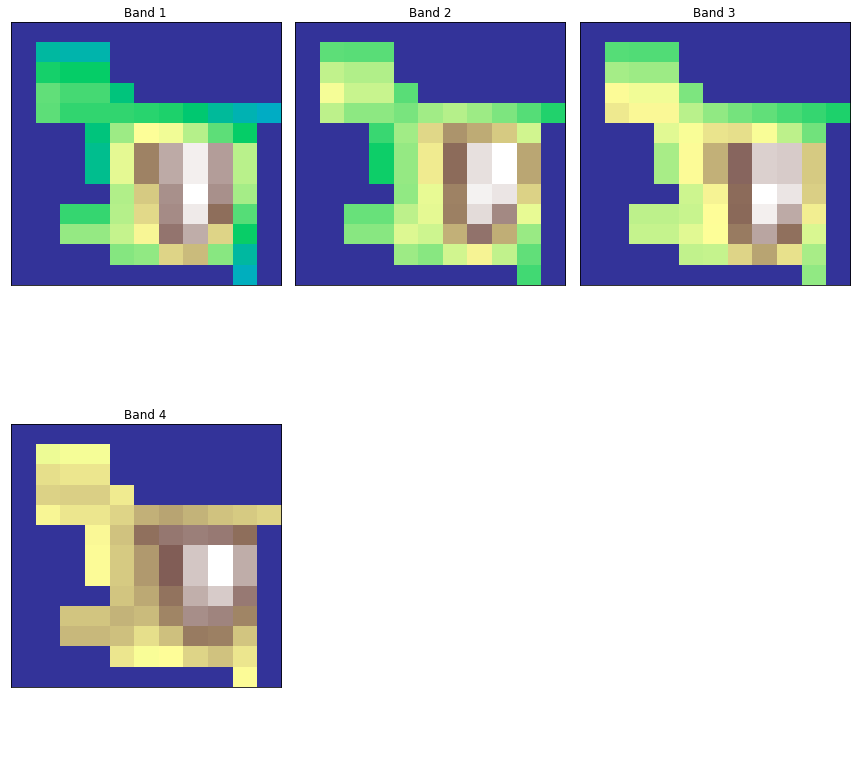

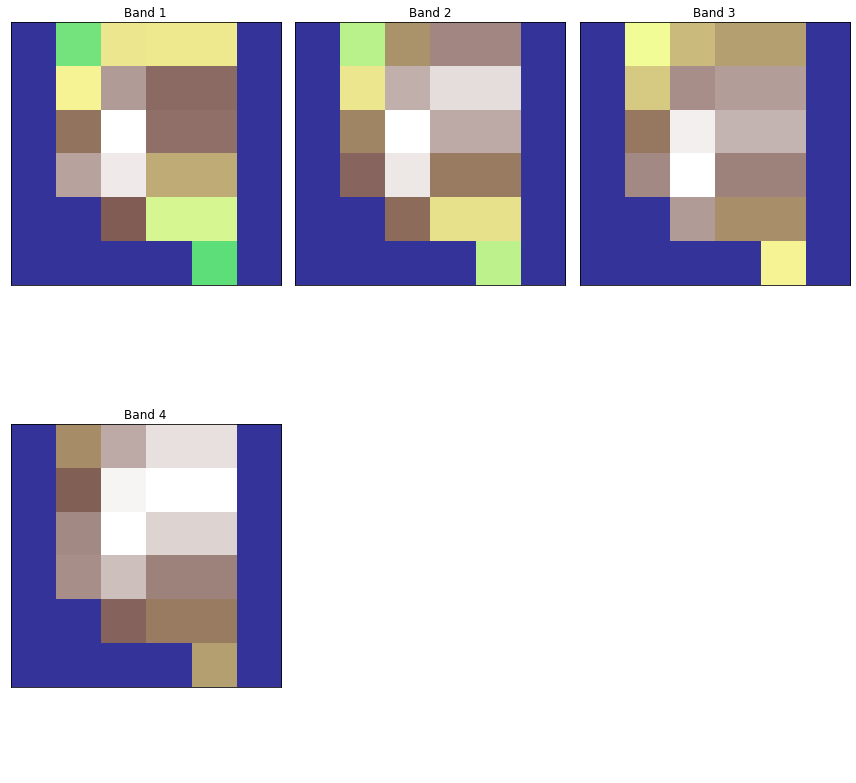

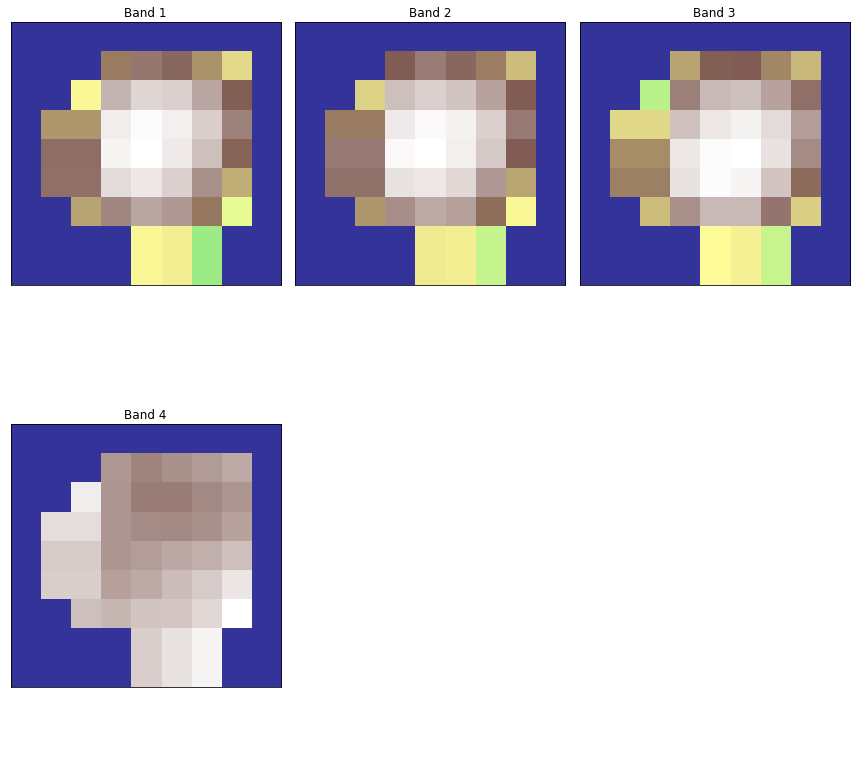

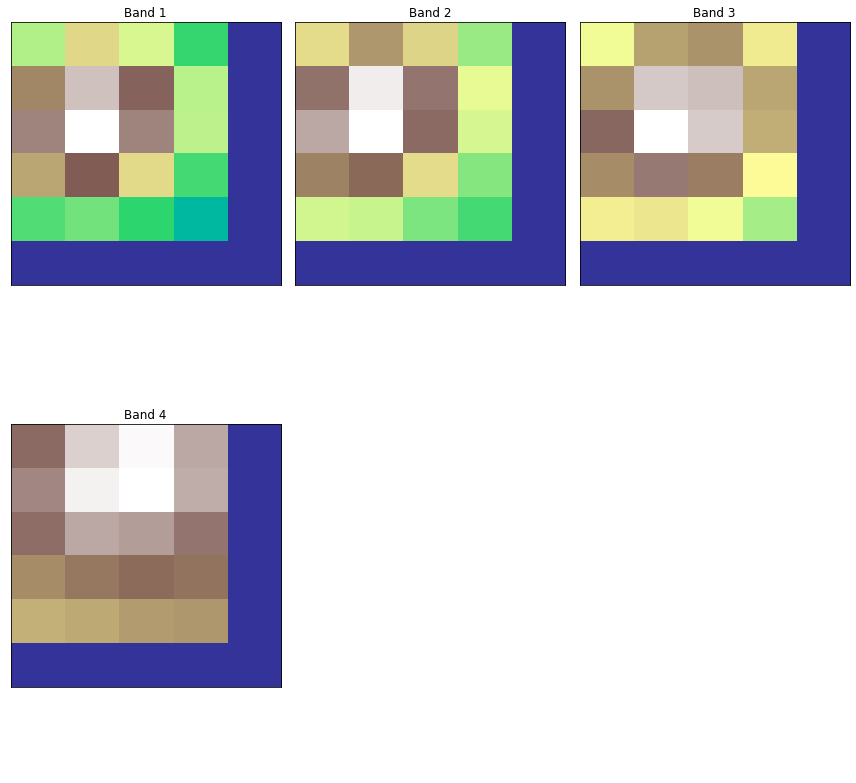

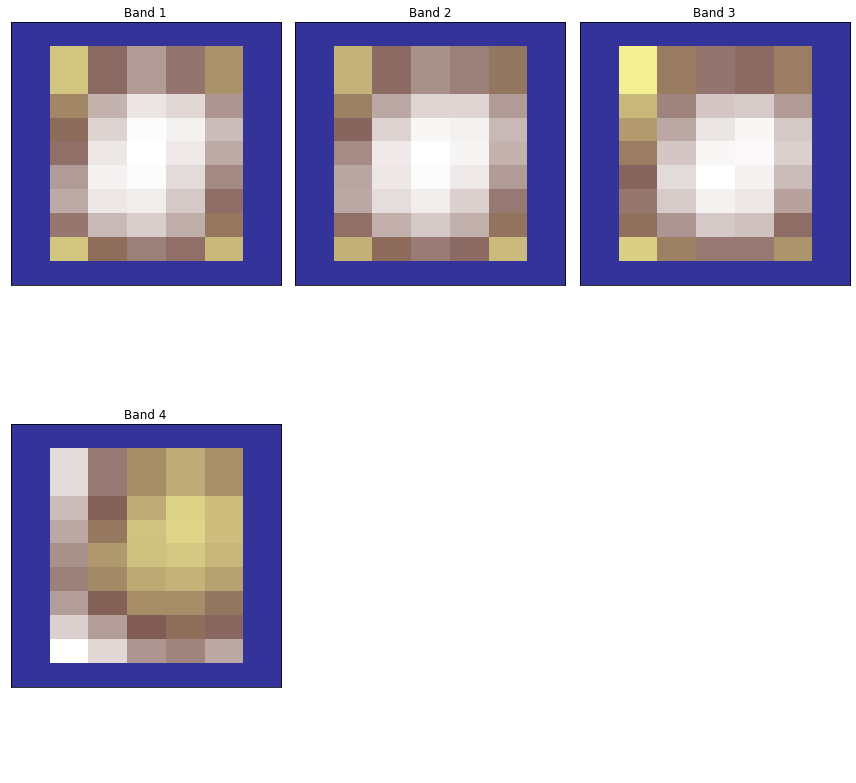

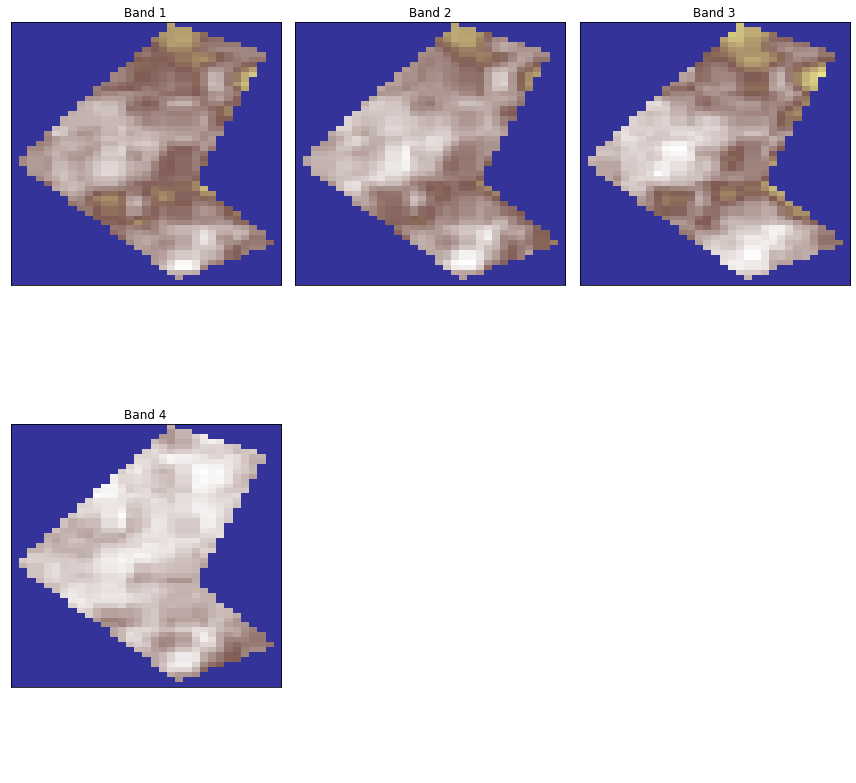

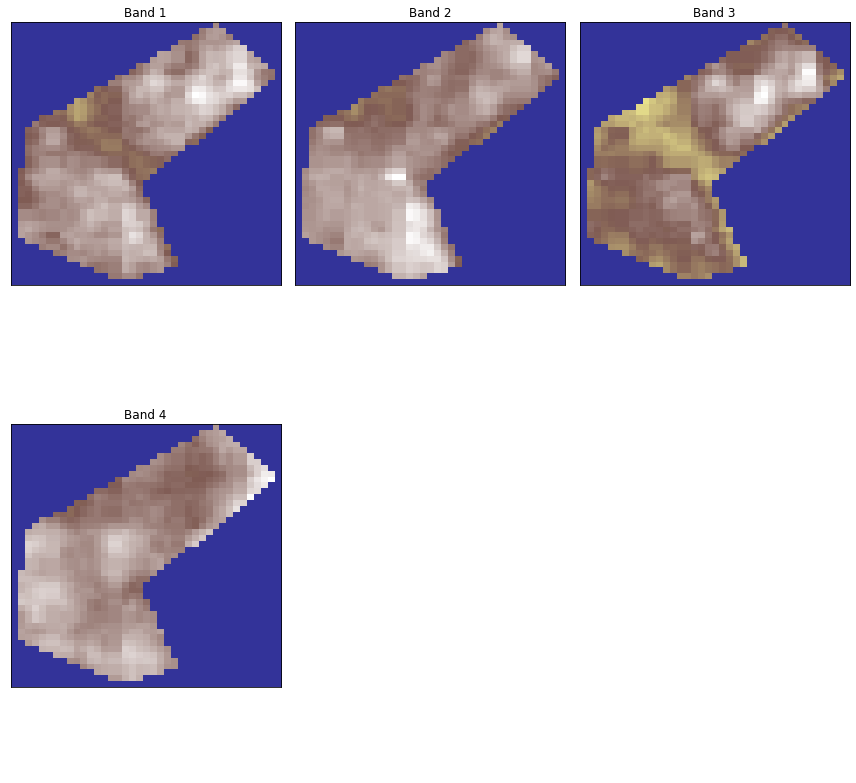

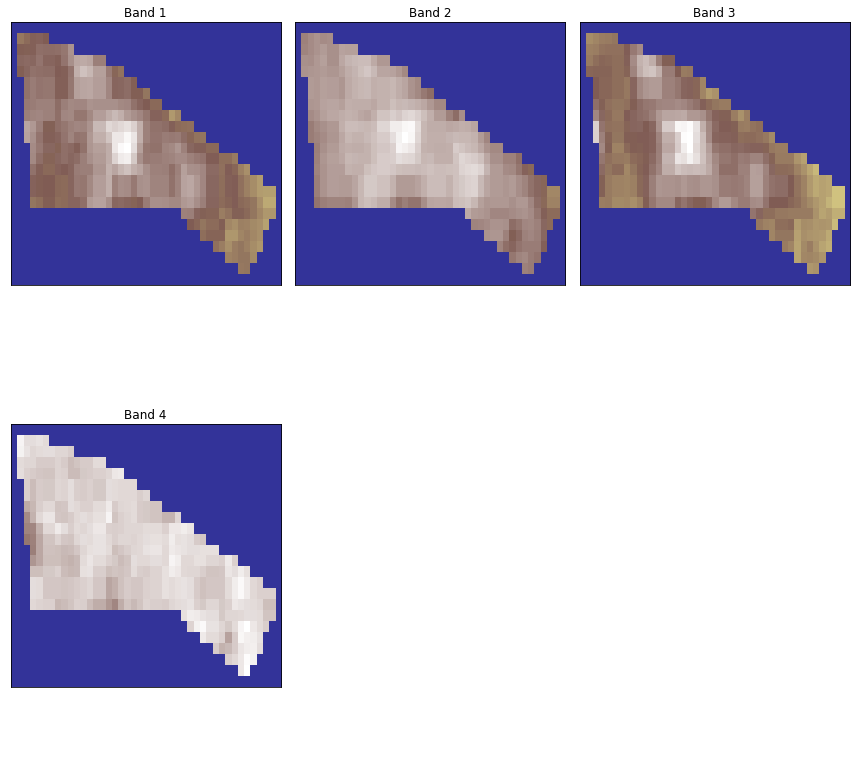

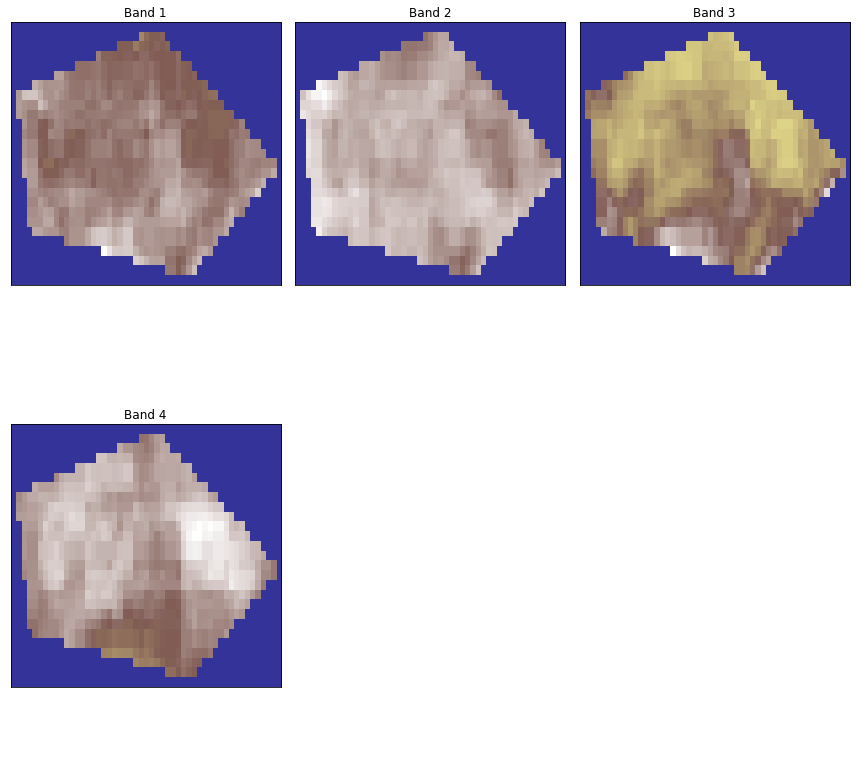

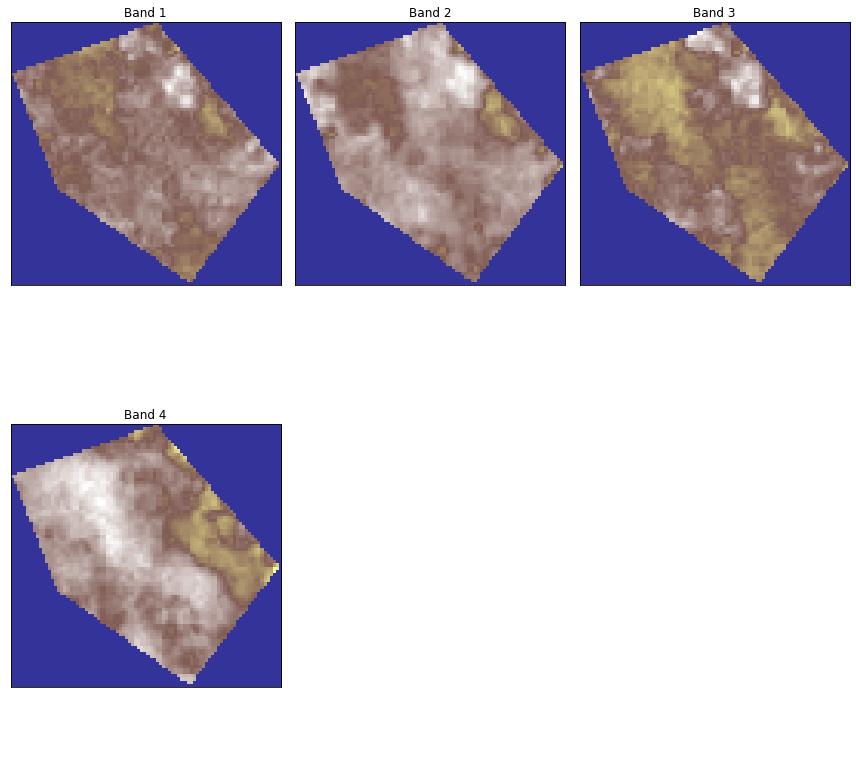

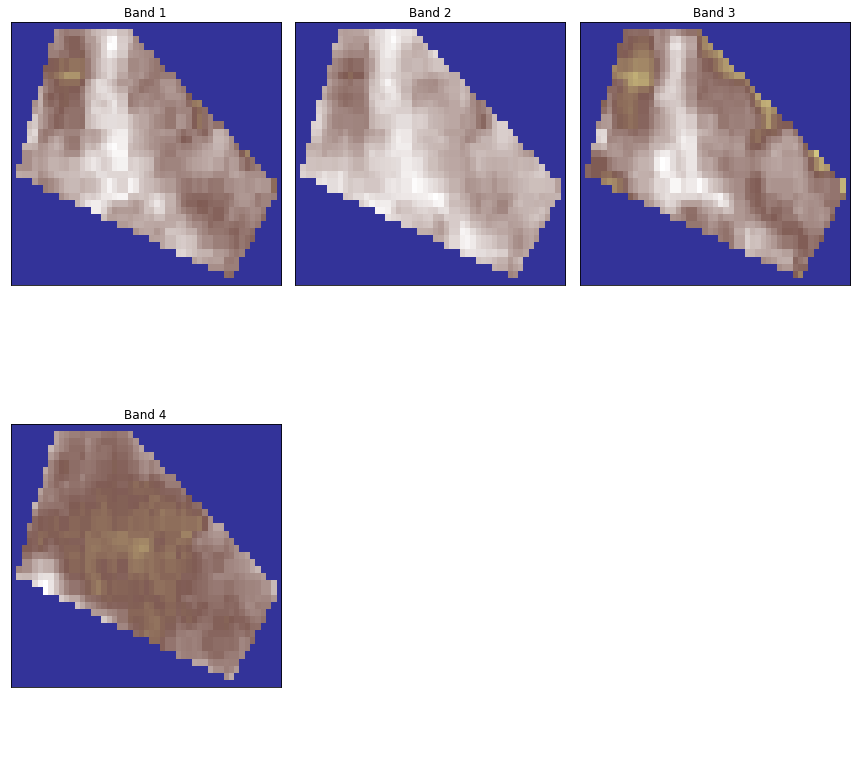

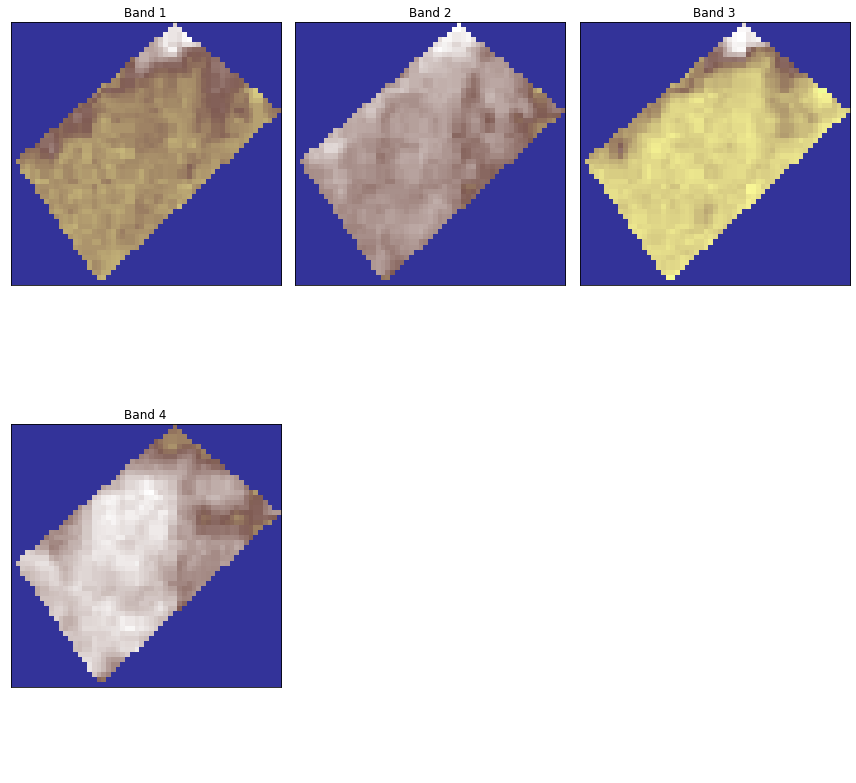

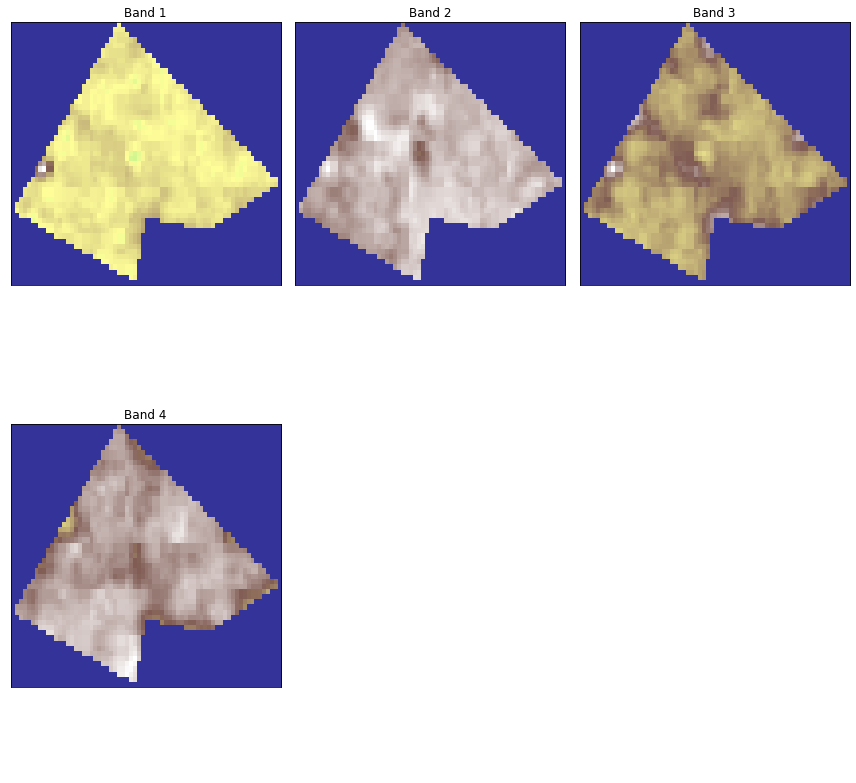

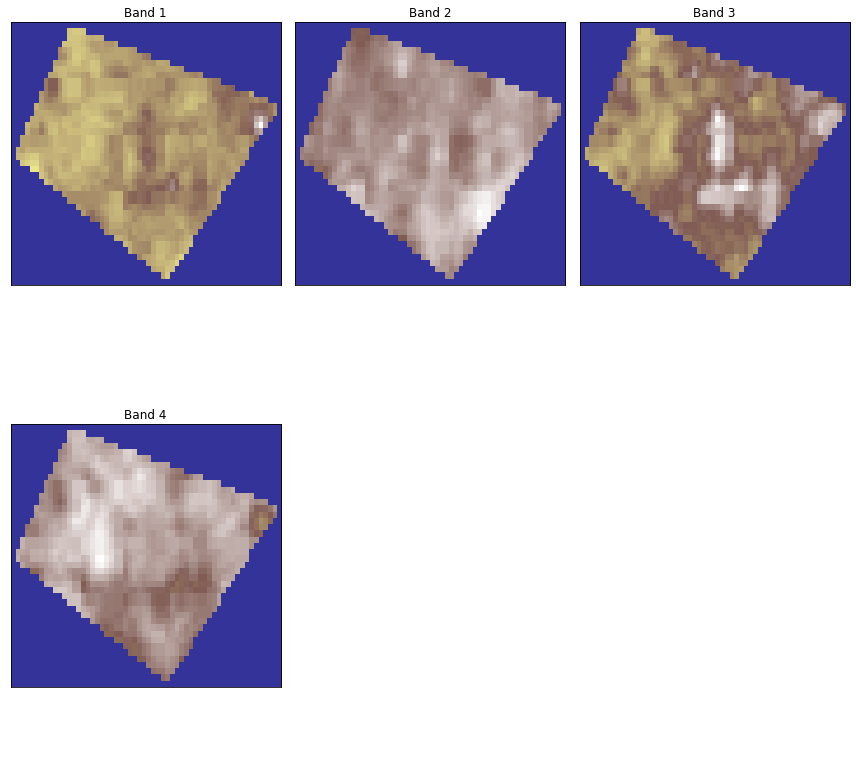

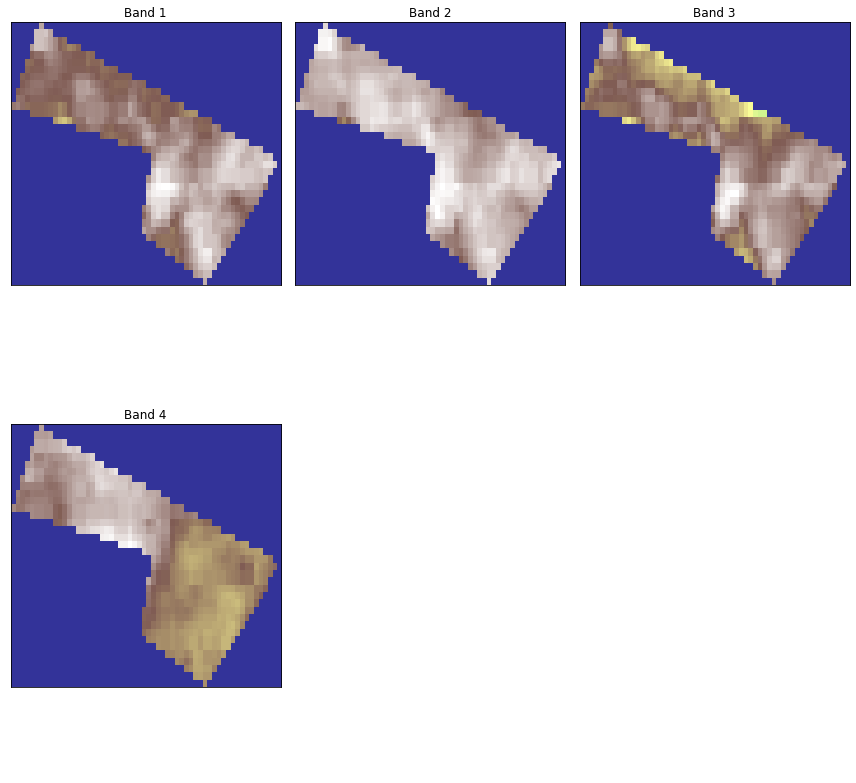

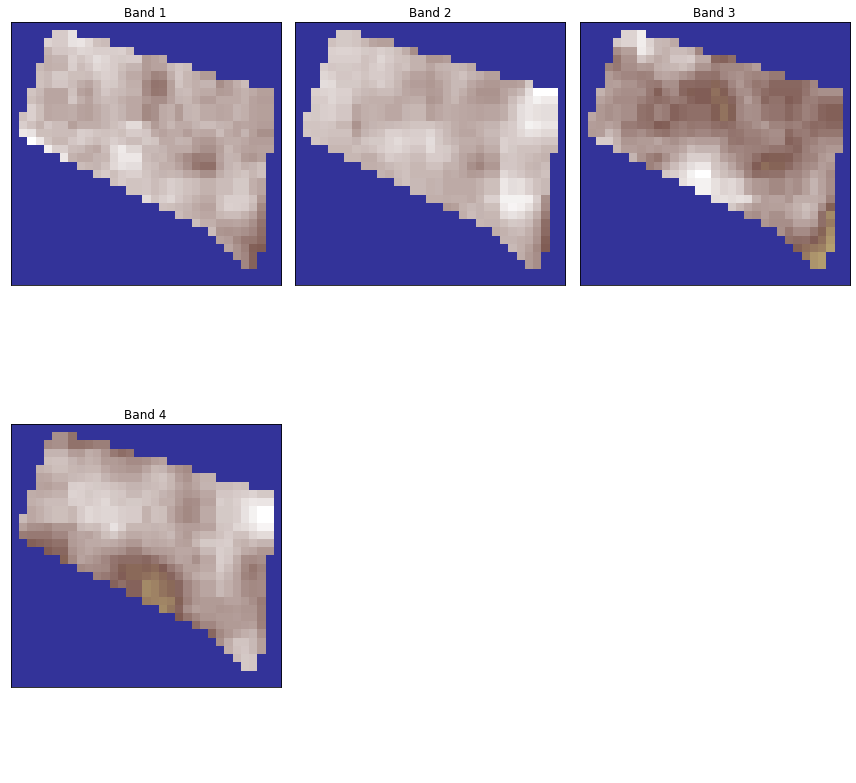

In [19]:
# Plot each masked image using polygons (training samples images)
for x in range(0,len(out_image_list)):
    ep.plot_bands(out_image_list[x][0],
               cmap='terrain',
               extent=extent,
               cbar=False);

# Define training vectors for RF

In [20]:
#remove zeros from arrayes (no-value pixels)
def remove_zero_columns(train_vec_np):
    return  train_vec_np[:,~np.all(train_vec_np == 0, axis=0)]

In [21]:
train_vec_np = np.zeros((4, 0))
target_vec_np = np.zeros((0))

for croped_image in crop_image_labed:
    train_vec = np.reshape(croped_image[0],(4,croped_image[0].shape[1]*croped_image[0].shape[2]))
    train_vec_nozero = remove_zero_columns(train_vec)
    train_vec_np = np.hstack([train_vec_np, train_vec_nozero])
    
    target_vec = np.full(train_vec_nozero.shape[1], croped_image[2])
    target_vec_np = np.hstack([target_vec_np, target_vec])
     
print(train_vec_np.shape)
print(target_vec_np.shape)

print("water " , np.sum(target_vec_np==1))
print("forest " , np.sum(target_vec_np==2))
print("agriculture ", np.sum(target_vec_np==3))
print("Deforestation " , np.sum(target_vec_np==4))
print("other " , np.sum(target_vec_np==5))


(4, 42039)
(42039,)
water  2073
forest  18998
agriculture  15130
Deforestation  4904
other  934


# Define Random Forest parameters

In [22]:
from sklearn.model_selection import train_test_split

X = train_vec_np.T   
y = target_vec_np

# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=None)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(31529, 4)
(10510, 4)
(31529,)


In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=8, random_state=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

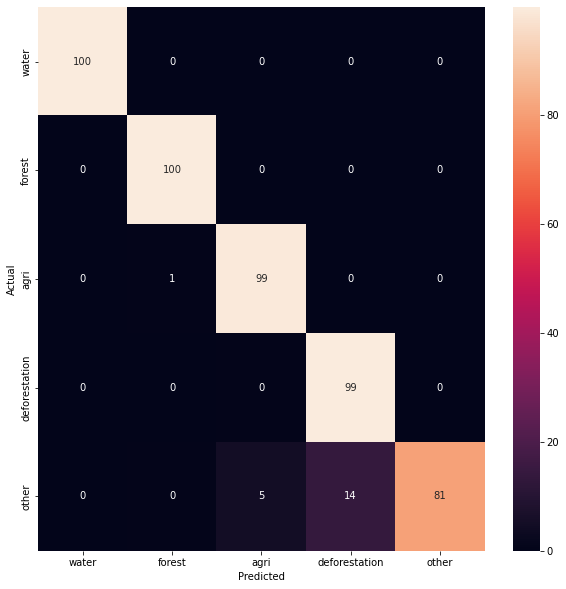

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] *100
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.0f', xticklabels=cl_unq, yticklabels=cl_unq)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Accuracy

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred, normalize=True)

0.991151284490961

# Precision & Recall

In [26]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print( 'Class Names: ', cl_unq)
print( 'precision: ', (precision_score(y_test, y_pred, average=None)))
print( 'recall: ', (recall_score(y_test, y_pred, average=None)))

Class Names:  ['water', 'forest', 'agri', 'deforestation', 'other']
precision:  [1.         0.99538203 0.99099815 0.97126895 0.99447514]
recall:  [0.99813433 0.99642782 0.99336518 0.99428105 0.80717489]


In [96]:
dataset=rasterio.open("/home/ubuntu/Space4Good/Combodia/Code/subset_1_1_of_Planet_Preylang_Sep2021_noval.tif")
band1 = dataset.read(1)
band2 = dataset.read(2)
band3 = dataset.read(3)
band4 = dataset.read(4)
band1_re = band1.reshape(band1.shape[0]*band1.shape[1],1)
band2_re = band2.reshape(band2.shape[0]*band2.shape[1],1)
band3_re = band3.reshape(band3.shape[0]*band3.shape[1],1)
band4_re = band4.reshape(band4.shape[0]*band4.shape[1],1)

img_feature = np.hstack((band1_re,band2_re,band3_re,band4_re))

In [97]:
import time
start_time = time.time()

classified = clf.predict(img_feature)
classified_re = classified.reshape((band1.shape[0],band1.shape[1]))
print("--- %s seconds ---" % (time.time() - start_time))

--- 442.3763449192047 seconds ---


In [98]:
# from matplotlib.colors import ListedColormap

# #discrete color scheme
# cMap = ListedColormap(['white','red','yellow','brown', 'green', 'blue'])

# # #data
# # np.random.seed(42)
# # data = np.random.rand(4, 4)
# fig, ax = plt.subplots()
# heatmap = ax.pcolor([1 2 3 4 5 6], cmap=cMap)

# #legend
# cbar = plt.colorbar(heatmap)

# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate(['$0$','$1$','$2$','$>3$','$>4$','$>5$']):
#     cbar.ax.text(.5, (2 * j + 1) / 8.0, lab, ha='center', va='center')
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('# of contacts', rotation=270)


# # # put the major ticks at the middle of each cell
# # ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
# # ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
# # ax.invert_yaxis()

# # #labels
# # column_labels = list('ABCD')
# # row_labels = list('WXYZ')
# # ax.set_xticklabels(column_labels, minor=False)
# # ax.set_yticklabels(row_labels, minor=False)

# plt.show()

{'water': 1, 'forest': 2, 'agri': 3, 'deforestation': 4, 'other': 5}


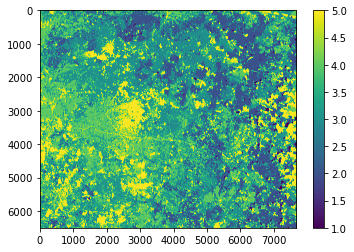

In [99]:

plt.imshow(classified_re)
plt.savefig(result_data)
plt.colorbar()
print(dict_cl_unq)
# plt.savefig('destination_path.eps', format='eps', dpi=1200)

In [100]:
result_data = os.path.join(base_dir, "Classified_preylang1-1")
raster_profile = dataset.profile
raster_profile.update(
        dtype=rasterio.float64,
        count=1,
        compress='lzw')
with rasterio.open(result_data, 'w', **raster_profile) as dst:
        dst.write((classified_re), indexes=1)